# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import copy
import pickle

# Dataset

In [2]:
with open('../../model/config.json', 'rb') as file:
    config = json.load(file)
csop_cols_to_ignore = config['csop']['cols_to_ignore']
csopII_cols_to_ignore = config['csopII']['cols_to_ignore']
csop_target, csopII_target = 'zscore_efficiency', 'efficiency'

In [3]:
csop_raw = pd.read_csv('../../output/csop_output_conversation_level.csv')
csop_all_features = csop_raw.drop(csop_cols_to_ignore, axis=1)
target_scaler = StandardScaler()
csop_all_features['target'] = target_scaler.fit_transform(csop_raw[csop_target].to_numpy().reshape(-1, 1))

csopII_raw = pd.read_csv('../../output/csopII_output_conversation_level.csv')
csopII_all_features = csopII_raw.drop(csopII_cols_to_ignore, axis=1)
csopII_all_features['target'] = target_scaler.transform(csopII_raw[csopII_target].to_numpy().reshape(-1, 1))

features = list(set(csop_all_features.columns).intersection(set(csopII_all_features.columns)))
csop, csopII = csop_all_features[features].copy(), csopII_all_features[features].copy()
csop, csopII = csop.fillna(0), csopII.fillna(0)

In [4]:
X, y = csop.drop(['target'], axis=1), csop[['target']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_test, y_test = csopII.drop(['target'], axis=1), csopII[['target']]

feature_scaler = StandardScaler()
X_train = pd.DataFrame(feature_scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns)
X_val = pd.DataFrame(feature_scaler.transform(X_val.to_numpy()), columns=X_val.columns)
X_test = pd.DataFrame(feature_scaler.transform(X_test.to_numpy()), columns=X_test.columns)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((882, 390), (98, 390), (962, 390), (882, 1), (98, 1), (962, 1))

In [5]:
feature_groupings_raw = pd.read_excel('feature_groupings_06_20_23.xlsx')
groups = feature_groupings_raw.columns[2:]
groups

Index(['Communication Frequency', 'Information / Knowledge Exchange',
       'Linguistic Features', 'Emotion', 'Cognitive Processes',
       'Perceptual Processes', 'Social Processes', 'Biological Processes',
       'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
       'Hedging', 'Politeness', 'Equality'],
      dtype='object')

In [6]:
rows = []
for idx, row in tqdm(feature_groupings_raw.iterrows(), total=feature_groupings_raw.shape[0]):
    if row['Level'] == 'Chat':
        for prefix in ['min_', 'max_', 'stdev_', 'average_']:
            feature_name = prefix + row['Feature Name']
            row_to_append = [feature_name] + row[groups].to_list()
            rows.append(row_to_append)
    else:
        feature_name = row['Feature Name']
        row_to_append = [feature_name] + row[groups].to_list()
        rows.append(row_to_append)
feature_groupings = pd.DataFrame(
    rows, 
    columns= [
        'Feature Name', 'Communication Frequency', 'Information / Knowledge Exchange',
        'Linguistic Features', 'Emotion', 'Cognitive Processes',
        'Perceptual Processes', 'Social Processes', 'Biological Processes',
        'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
        'Hedging', 'Politeness', 'Equality'
    ]
)

100%|██████████| 99/99 [00:00<00:00, 1949.58it/s]


## Creating Data Loaders

In [7]:
class CSOPDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [8]:
train_dataset = CSOPDataset(X=X_train.to_numpy(), y=y_train.to_numpy())
val_dataset = CSOPDataset(X=X_val.to_numpy(), y=y_val.to_numpy())

In [9]:
torch.manual_seed(42)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

# Fully Connected Neural Network Optimization

## Helper Functions

In [10]:
def calc_nn_metrics(y_true, y_pred, type='TRAIN'):
    r2 = r2_score(y_true=y_true, y_pred=y_pred).round(4)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred).round(4)
    rmse = np.sqrt(mse).round(4)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred).round(4)

    return {'r2': r2, 'mse': mse, 'mae': mae, 'rmse': rmse}

In [11]:
class CSOPFullyConnectedNN(nn.Module):
    def __init__(self, num_input_features, num_hidden_layer_nodes=15):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=num_input_features, out_features=num_hidden_layer_nodes),
            nn.ReLU(),
            nn.Linear(in_features=num_hidden_layer_nodes, out_features=1)
        )

    def forward(self, X):
        return self.net(X)

In [12]:
num_hidden_layer_nodes = list(range(1, 101))
models = [CSOPFullyConnectedNN(num_input_features=X_train.shape[1], num_hidden_layer_nodes=num_hidden_layer_node) \
          for num_hidden_layer_node in num_hidden_layer_nodes]
model_names = ['num_hidden_nodes_'+str(num_nodes) for num_nodes in num_hidden_layer_nodes]
learning_rates = [0.000001, 0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003]
max_epochs_list = [50, 100, 250, 500, 1000]

In [13]:
def train(model, datasets, dataloaders, num_hidden_layer_neurons=15, learning_rate=0.00003, max_epochs=200):
    X_train, X_val, y_train, y_val = datasets
    train_dataloader, val_dataloader = dataloaders
    best_mse = float('inf')
    best_weights = None
    train_losses, val_losses = [], []

    loss_fn = nn.MSELoss()
    optimizer = Adam(params=model.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):
        # Training for one epoch
        model.train()
        train_loss = 0
        for (X_batch, y_batch) in train_dataloader:
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            # Weights Updates
            optimizer.step()
            train_loss += float(loss)
        # Calculating average training loss after one epoch
        avg_train_mse_loss = float(train_loss/len(train_dataloader))
        train_losses.append(avg_train_mse_loss)
        # writer.add_scalar('Training Loss', avg_train_mse_loss, epoch)
        # Validation after one epoch
        model.eval()
        val_loss = 0
        for X_batch, y_batch in val_dataloader:
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = model(X_batch)
            val_mse_loss = loss_fn(y_pred, y_batch)
            val_loss += float(val_mse_loss)
        # Calculating average validation loss after one epoch
        avg_val_mse_loss = float(val_loss/len(val_dataloader))
        val_losses.append(avg_val_mse_loss)
        # writer.add_scalar('Validation Loss', avg_val_mse_loss, epoch)
        # Checking if we improved from the previous best epoch
        if avg_val_mse_loss < best_mse:
            best_mse = avg_val_mse_loss
            best_weights = copy.deepcopy(model.state_dict())
            best_epoch = epoch
    
    train_preds = model(torch.tensor(X_train.to_numpy(), dtype=torch.float32)).detach().numpy()
    val_preds = model(torch.tensor(X_val.to_numpy(), dtype=torch.float32)).detach().numpy()
    train_metrics = calc_nn_metrics(y_true=y_train, y_pred=train_preds, type='TRAIN')
    val_metrics = calc_nn_metrics(y_true=y_val, y_pred=val_preds, type='VALIDATIOn')
    

    model.load_state_dict(best_weights)
    model_cache = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': min(val_losses),
        'num_hidden_layer_neurons': num_hidden_layer_neurons,
        'learning_rate': learning_rate,
        'max_epochs': max_epochs,
        'best_epoch': best_epoch,
        'train_r2': train_metrics['r2'],
        'train_mse': train_metrics['mse'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_r2': val_metrics['r2'],
        'val_mse': val_metrics['mse'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
    }
    return model_cache

## Optimization Loop (Takes ~8 Hours)

In [16]:
model_performances = pd.DataFrame(
    columns=[
        'model', 
        'net.0.weight', 'net.0.bias',
        'net.2.weight', 'net.2.bias',
        'num_hidden_layer_neurons', 
        'learning_rate', 'max_epochs', 
        'best_epoch', 'best_val_loss',
        'train_losses', 'val_losses',
        'train_r2', 'train_mse', 'train_rmse', 'train_mae',
        'val_r2', 'val_mse', 'val_rmse', 'val_mae'
    ]
)
for num_hidden_layer_neurons, model in tqdm(enumerate(models), total=len(models)):
    for learning_rate in learning_rates:
        for max_epoch in max_epochs_list:
            model_cache = train(
                model=model, 
                datasets=(X_train, X_val, y_train, y_val),
                dataloaders=(train_dataloader, val_dataloader),
                num_hidden_layer_neurons=num_hidden_layer_neurons+1, 
                learning_rate=learning_rate, 
                max_epochs=max_epoch
            )
            model_performances = pd.concat([
                model_performances,
                pd.DataFrame(
                    index=model_performances.columns, 
                    data=[
                        model_cache['model'],
                        list(model_cache['model'].state_dict()['net.0.weight'].numpy().reshape((-1,))), 
                        list(model_cache['model'].state_dict()['net.0.bias'].numpy().reshape((-1,))),
                        list(model_cache['model'].state_dict()['net.2.weight'].numpy().reshape((-1,))), 
                        list(model_cache['model'].state_dict()['net.2.bias'].numpy().reshape((-1,))),
                        model_cache['num_hidden_layer_neurons'],
                        model_cache['learning_rate'],
                        model_cache['max_epochs'],
                        model_cache['best_epoch'],
                        model_cache['best_val_loss'],
                        model_cache['train_losses'],
                        model_cache['val_losses'],
                        model_cache['train_r2'],
                        model_cache['train_mse'],
                        model_cache['train_rmse'],
                        model_cache['train_mae'],
                        model_cache['val_r2'],
                        model_cache['val_mse'],
                        model_cache['val_rmse'],
                        model_cache['val_mae']
                    ]
                ).T
            ], ignore_index=True)
            with open('model_performances.pkl', 'wb') as file:
                pickle.dump(model_performances, file)
            break
        break
    break

  0%|          | 0/100 [00:00<?, ?it/s]


In [17]:
model_performances

model  \
0  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   

                                        net.0.weight      net.0.bias  \
0  [0.038720276, 0.042104278, -0.011993179, 0.046...  [-0.010061328]   

    net.2.weight net.2.bias num_hidden_layer_neurons learning_rate max_epochs  \
0  [-0.41708812]  [0.68899]                        1      0.000001         50   

  best_epoch best_val_loss                                       train_losses  \
0         19      1.450174  [1.3813255088669913, 1.3823513729231698, 1.374...   

                                          val_losses train_r2 train_mse  \
0  [1.5607509016990662, 1.645142138004303, 1.6029...  -0.3965    1.3792   

  train_rmse train_mae  val_r2 val_mse val_rmse val_mae  
0     1.1744    1.0007 -0.4534  1.6032   1.2662  1.0882

In [18]:
with open('model_performances.pkl', 'rb') as file:
    loaded_model_performances = pickle.load(file)

In [19]:
loaded_model_performances

model  \
0  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   

                                        net.0.weight      net.0.bias  \
0  [0.038720276, 0.042104278, -0.011993179, 0.046...  [-0.010061328]   

    net.2.weight net.2.bias num_hidden_layer_neurons learning_rate max_epochs  \
0  [-0.41708812]  [0.68899]                        1      0.000001         50   

  best_epoch best_val_loss                                       train_losses  \
0         19      1.450174  [1.3813255088669913, 1.3823513729231698, 1.374...   

                                          val_losses train_r2 train_mse  \
0  [1.5607509016990662, 1.645142138004303, 1.6029...  -0.3965    1.3792   

  train_rmse train_mae  val_r2 val_mse val_rmse val_mae  
0     1.1744    1.0007 -0.4534  1.6032   1.2662  1.0882

In [20]:
(model_performances == loaded_model_performances)

model  net.0.weight  net.0.bias  net.2.weight  net.2.bias  \
0  False          True        True          True        True   

   num_hidden_layer_neurons  learning_rate  max_epochs  best_epoch  \
0                      True           True        True        True   

   best_val_loss  train_losses  val_losses  train_r2  train_mse  train_rmse  \
0           True          True        True      True       True        True   

   train_mae  val_r2  val_mse  val_rmse  val_mae  
0       True    True     True      True     True

In [37]:
pd.DataFrame(
    index=model_performances.columns, 
    data=[
        model_cache['model'],
        list(model_cache['model'].state_dict()['net.0.weight'].numpy().reshape((-1,))), 
        list(model_cache['model'].state_dict()['net.0.bias'].numpy().reshape((-1,))),
        list(model_cache['model'].state_dict()['net.2.weight'].numpy().reshape((-1,))), 
        list(model_cache['model'].state_dict()['net.2.bias'].numpy().reshape((-1,))),
        model_cache['num_hidden_layer_neurons'],
        model_cache['learning_rate'],
        model_cache['max_epochs'],
        model_cache['best_epoch'],
        model_cache['best_val_loss'],
        model_cache['train_losses'],
        model_cache['val_losses'],
        model_cache['train_r2'],
        model_cache['train_mse'],
        model_cache['train_rmse'],
        model_cache['train_mae'],
        model_cache['val_r2'],
        model_cache['val_mse'],
        model_cache['val_rmse'],
        model_cache['val_mae']
    ]
).T
    # {
    #                 'model': model_cache['model'],
    #                 # 'net.0.weight': model_cache['model'].state_dict()['net.0.weight'], 
    #                 # 'net.0.bias': model_cache['model'].state_dict()['net.0.bias'],
    #                 # 'net.2.weight': model_cache['model'].state_dict()['net.2.weight'], 
    #                 # 'net.2.bias': model_cache['model'].state_dict()['net.2.bias'],

    #                 'net.0.weight': list(model_cache['model'].state_dict()['net.0.weight'].numpy().reshape((-1,))), 
    #                 'net.0.bias': list(model_cache['model'].state_dict()['net.0.bias'].numpy().reshape((-1,))),
    #                 'net.2.weight': list(model_cache['model'].state_dict()['net.2.weight'].numpy().reshape((-1,))), 
    #                 'net.2.bias': list(model_cache['model'].state_dict()['net.2.bias'].numpy().reshape((-1,))),
    #                 'num_hidden_layer_neurons': model_cache['num_hidden_layer_neurons'],
    #                 'learning_rate': model_cache['learning_rate'],
    #                 'max_epochs': model_cache['max_epochs'],
    #                 'best_epoch': model_cache['best_epoch'],
    #                 'best_val_loss': model_cache['best_val_loss'],
    #                 'train_losses': model_cache['train_losses'],
    #                 'val_losses': model_cache['val_losses'],
    #                 'train_r2': model_cache['train_r2'],
    #                 'train_mse': model_cache['train_mse'],
    #                 'train_rmse': model_cache['train_rmse'],
    #                 'train_mae': model_cache['train_mae'],
    #                 'val_r2': model_cache['val_r2'],
    #                 'val_mse': model_cache['val_mse'],
    #                 'val_rmse': model_cache['val_rmse'],
    #                 'val_mae': model_cache['val_mae']
    #             })

model  \
0  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   

                                        net.0.weight      net.0.bias  \
0  [-0.037057936, -0.027499411, -0.02439905, 0.04...  [-0.035441022]   

   net.2.weight     net.2.bias num_hidden_layer_neurons learning_rate  \
0  [0.16262247]  [-0.68489367]                        0      0.000001   

  max_epochs best_epoch best_val_loss  \
0         50         40      1.165913   

                                        train_losses  \
0  [1.398450297968728, 1.4005380017416817, 1.4086...   

                                          val_losses train_r2 train_mse  \
0  [1.4029235243797302, 1.5094438791275024, 1.383...  -0.4105     1.393   

  train_rmse train_mae  val_r2 val_mse val_rmse val_mae  
0     1.1803    0.8306 -0.2677  1.3983   1.1825  0.8536

In [33]:
list(model_cache['model'].state_dict()['net.0.weight'].numpy().reshape((-1,)))

[-0.036574006,
 -0.027499411,
 -0.023849119,
 0.046020765,
 0.032098427,
 -0.020564377,
 -0.023120845,
 0.011388531,
 0.0011039135,
 0.03703827,
 0.03507949,
 -0.019377189,
 0.0028016067,
 -0.021530794,
 0.007964553,
 0.02791543,
 0.042252798,
 -0.031597678,
 -0.0010955014,
 -0.0502966,
 0.004000558,
 -0.007903294,
 -0.039350152,
 -0.023961816,
 -0.035037342,
 0.026370933,
 -0.03281329,
 -0.019028625,
 -0.028237067,
 0.023697535,
 -0.013695756,
 -0.022388464,
 0.04514213,
 0.024282107,
 -0.024874272,
 -0.016538093,
 0.027533978,
 -0.021471918,
 -0.019452287,
 0.04798066,
 -0.042085998,
 -0.023157196,
 -0.006894424,
 -0.03705835,
 -0.0068733515,
 -0.039003853,
 0.02001928,
 0.012080833,
 -0.049221423,
 0.025662882,
 -0.01913312,
 0.03790679,
 -0.01194894,
 0.0485782,
 -0.02350929,
 0.042565476,
 0.041699484,
 -0.047208466,
 -0.025508063,
 -0.0138647705,
 0.016560793,
 -0.00327339,
 0.026307538,
 -0.03899334,
 -0.023067778,
 -0.013443339,
 -0.03647172,
 0.036384705,
 -0.041348793,
 0.025

In [25]:
for param_name in model_cache['model'].state_dict():
    print(param_name, model_cache['model'].state_dict()[param_name])

net.0.weight tensor([[-0.0363, -0.0275, -0.0235,  0.0462,  0.0324, -0.0202, -0.0228,  0.0117,
          0.0014,  0.0374,  0.0354, -0.0191,  0.0031, -0.0212,  0.0083,  0.0282,
          0.0423, -0.0313, -0.0008, -0.0500,  0.0043, -0.0076, -0.0390, -0.0239,
         -0.0347,  0.0267, -0.0325, -0.0187, -0.0279,  0.0240, -0.0134, -0.0221,
          0.0455,  0.0246, -0.0246, -0.0162,  0.0278, -0.0215, -0.0191,  0.0483,
         -0.0418, -0.0228, -0.0066, -0.0367, -0.0066, -0.0387,  0.0203,  0.0124,
         -0.0489,  0.0260, -0.0188,  0.0382, -0.0116,  0.0489, -0.0232,  0.0429,
          0.0420, -0.0469, -0.0252, -0.0139,  0.0169, -0.0030,  0.0266, -0.0390,
         -0.0228, -0.0131, -0.0362,  0.0367, -0.0410,  0.0259, -0.0237, -0.0303,
          0.0217, -0.0089,  0.0344, -0.0338, -0.0368,  0.0059, -0.0365,  0.0074,
         -0.0191, -0.0471,  0.0376,  0.0069,  0.0033, -0.0014,  0.0090,  0.0130,
          0.0459, -0.0408,  0.0488, -0.0188, -0.0210, -0.0449,  0.0331,  0.0296,
         -0.011

## Saving Model Performances

In [19]:
# import pickle
# with open('model_performances.pkl', 'wb') as file_handle:
#     pickle.dump(model_performances, file_handle)

## Loading Model Performances and Visualization

In [15]:
with open('model_performances.pkl', 'rb') as file_handle:
    model_performances = pickle.load(file_handle)

In [27]:
sorted_model_performances.head(20)

model  \
2810  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
3089  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
2729  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
2811  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
969   CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
2129  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
1969  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
2728  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
1968  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
3088  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
2732  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
3087  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
1971  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
1973  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
2249  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
294   CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
2648  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
3809  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
2808  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   
2809  CSOPFullyConnectedNN(\n  (net): Sequential(\n ...   

     num_hidden_layer_neurons  learning_rate max_epochs best_epoch  \
2810                       70       0.000010         50         39   
3089                       77       0.000003       1000         31   
2729                       68       0.000003       1000         52   
2811                       70       0.000010        100         22   
969                        24       0.000003       1000        874   
2129                       53       0.000003       1000        424   
1969                       49       0.000003       1000        224   
2728                       68       0.000003        500        263   
1968                       49       0.000003        500        135   
3088                       77       0.000003        500        372   
2732                       68       0.000010        250         26   
3087                       77       0.000003        250         84   
1971                       49       0.000010        100         44   
1973                       49       0.000010        500         11   
2249                       56       0.000003       1000        765   
294                         7       0.000010       1000        706   
2648                       66       0.000003        500        365   
3809                       95       0.000003       1000         23   
2808                       70       0.000003        500        427   
2809                       70       0.000003       1000          5   

      best_val_loss                                       train_losses  \
2810       0.627438  [0.6868786045483181, 0.6761542750256402, 0.672...   
3089       0.642208  [0.6720703669956752, 0.6707057910306113, 0.669...   
2729       0.642918  [0.674226422395025, 0.6756276445729392, 0.6798...   
2811       0.643305  [0.6636330911091396, 0.6658722502844674, 0.670...   
969        0.648116  [0.7206461685044425, 0.7195225187710353, 0.716...   
2129       0.648328  [0.6829339138099125, 0.6818415735449109, 0.685...   
1969       0.648717  [0.7023829902921405, 0.6976076598678317, 0.701...   
2728       0.650843  [0.6833223615373883, 0.7011609716074807, 0.688...   
1968       0.652236  [0.7144106839384351, 0.7045889581952777, 0.708...   
3088       0.654597  [0.6990027512822833, 0.7018172528062548, 0.694...   
2732       0.654697  [0.6595297987971988, 0.6620869955846241, 0.660...   
3087       0.655762  [0.7011945226362774, 0.7105320521763393, 0.711...   
1971       0.656793  [0.6988890085901532, 0.6856845979179654, 0.683...   
1973       0.656958  [0.6762501065220151, 0.6747133902141026, 0.678...   
2249       0.657134  [0.7034914195537567, 0.7059711771351951, 0.701...   
294        0.658218  [0.7145131762538638, 0.70895203096526, 0.71103...   
2648       0.659212  [0.6993240267038345, 0.7027479835918972, 0.704...   
3809   

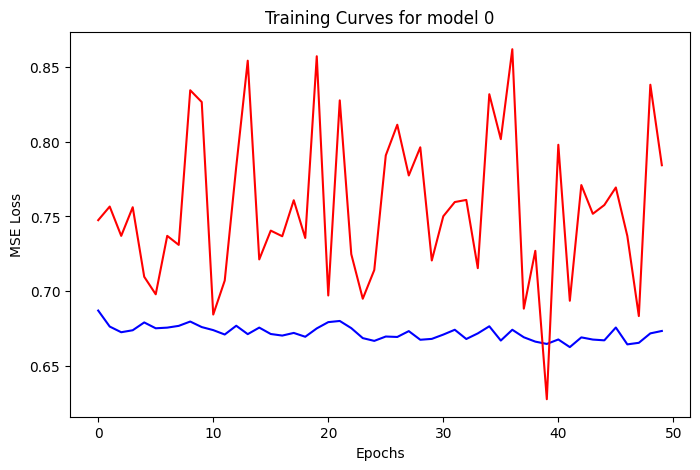

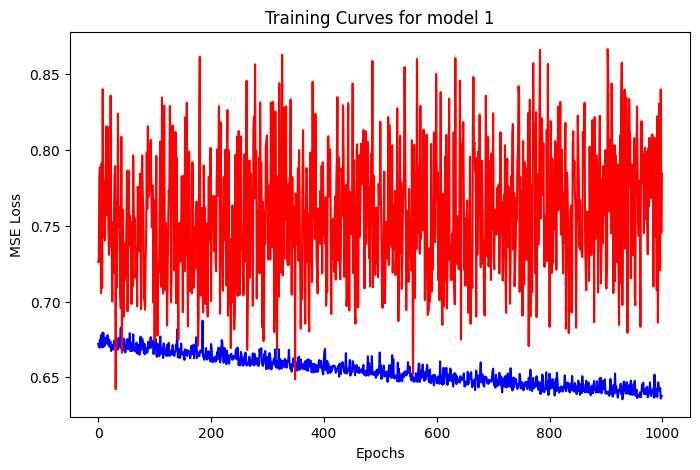

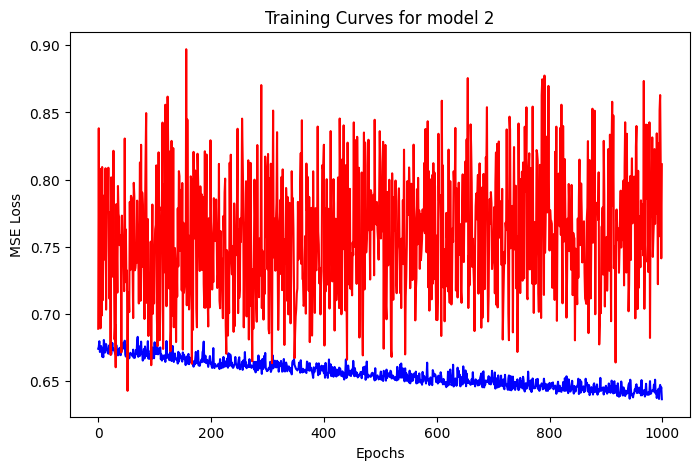

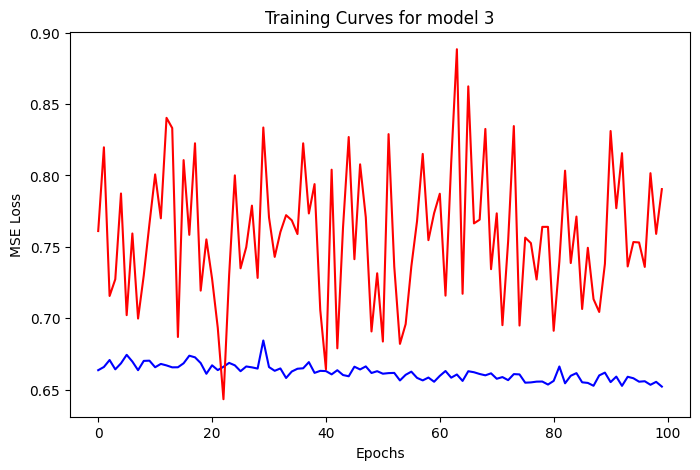

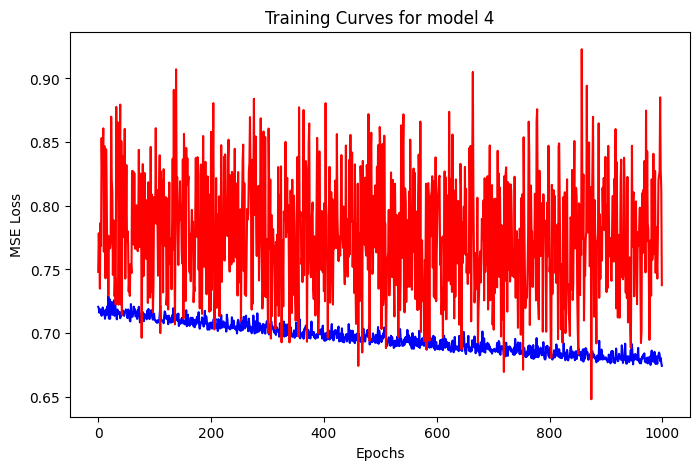

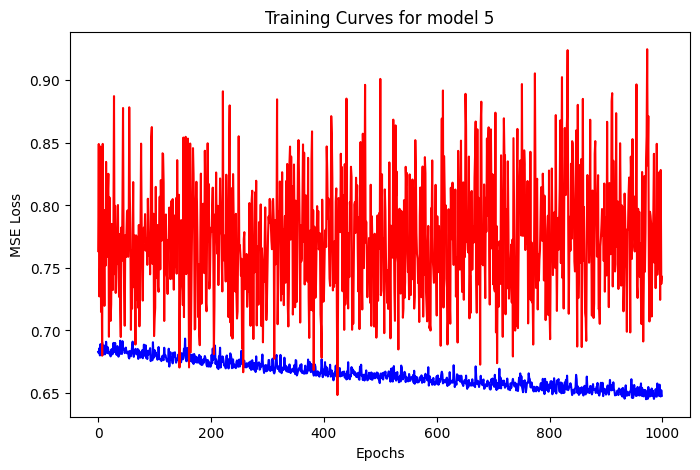

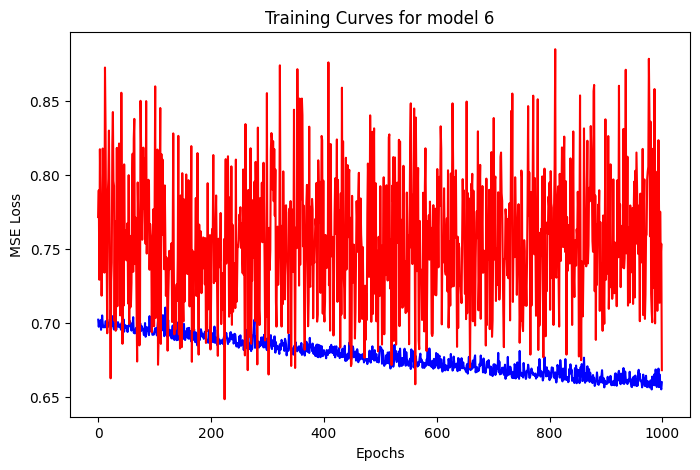

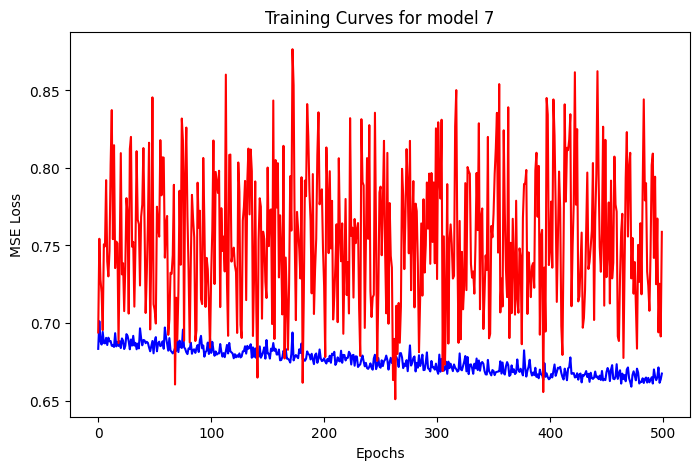

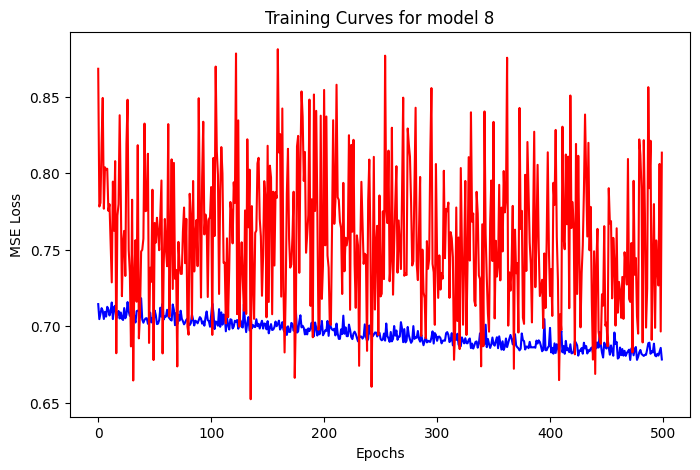

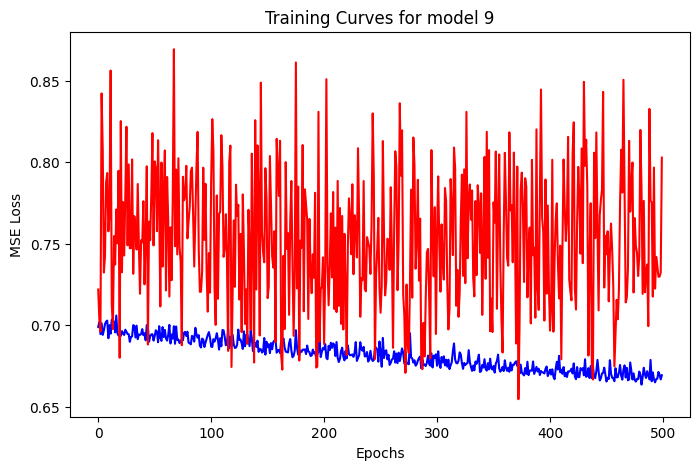

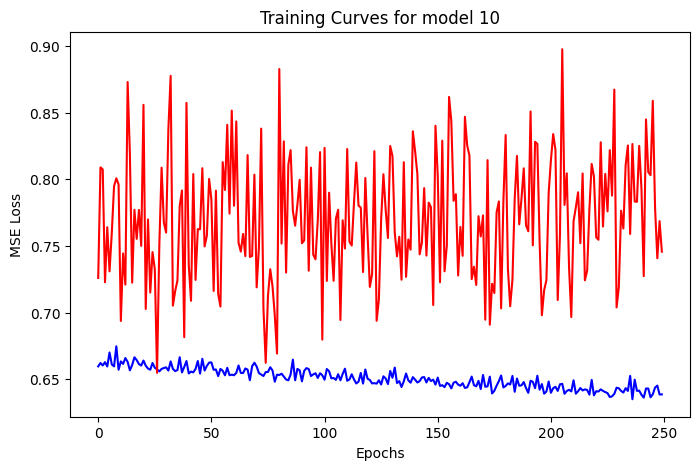

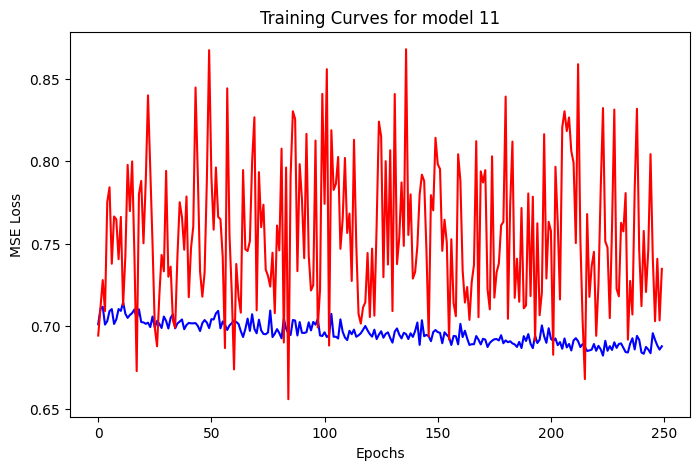

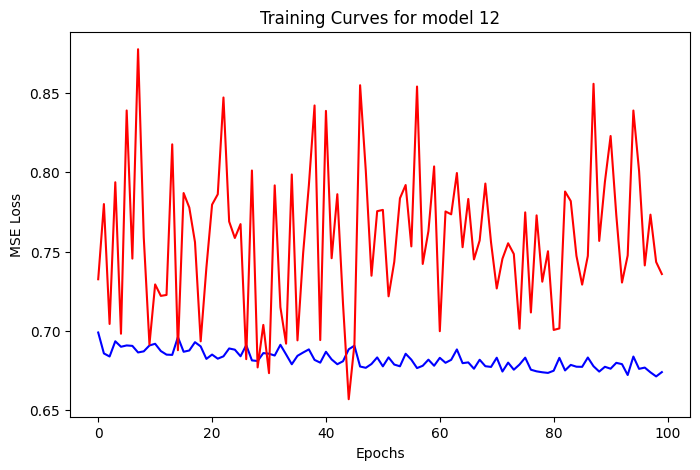

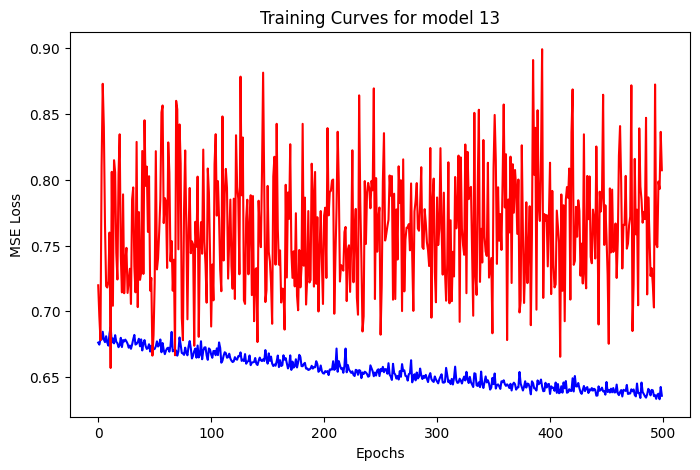

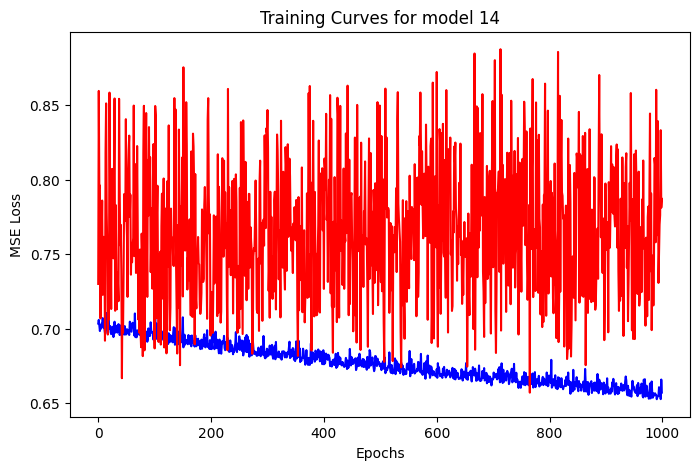

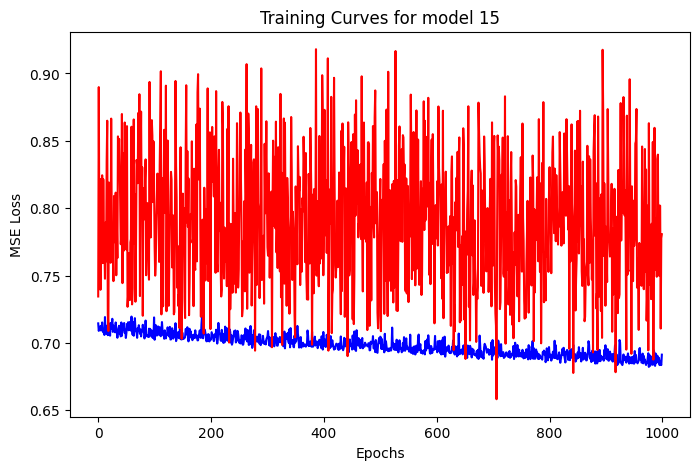

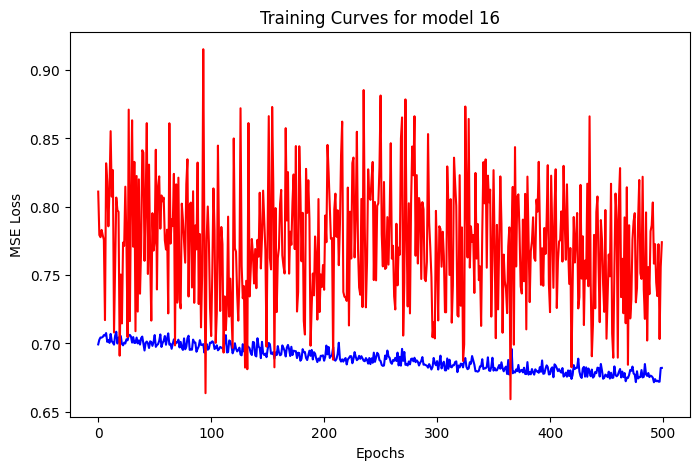

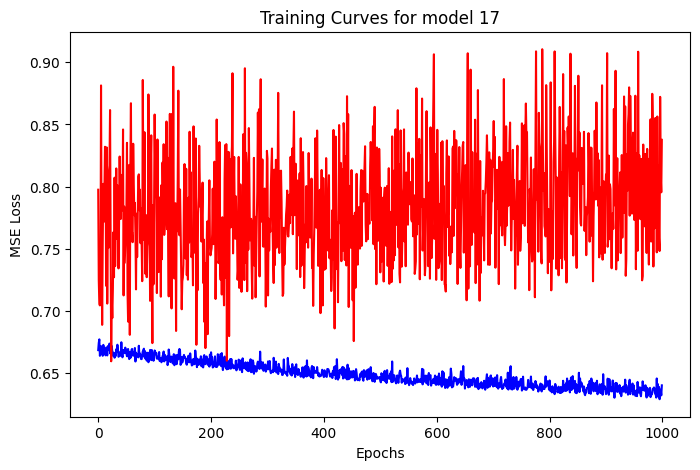

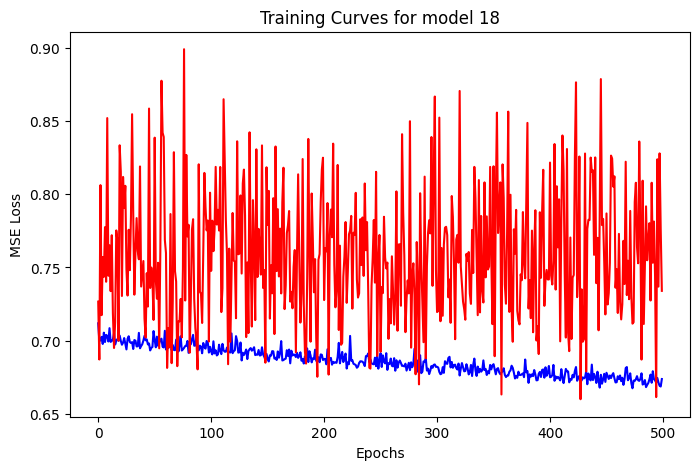

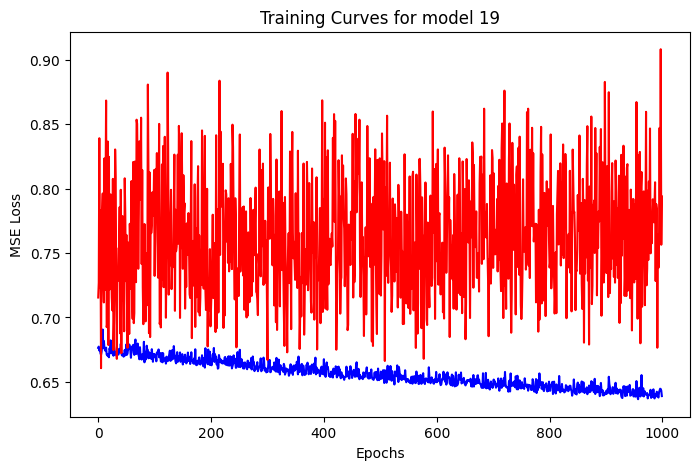

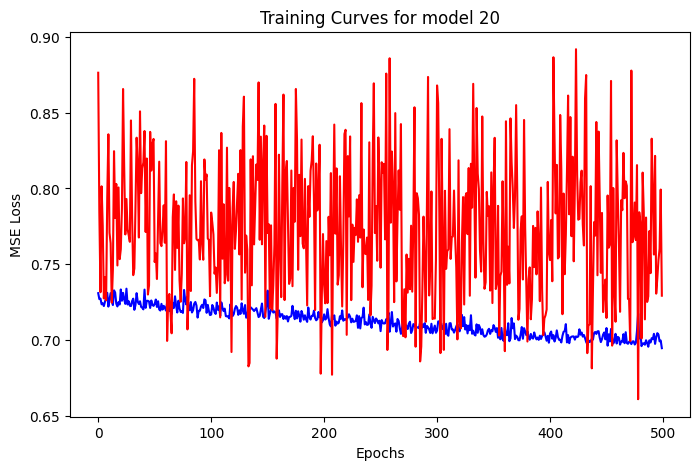

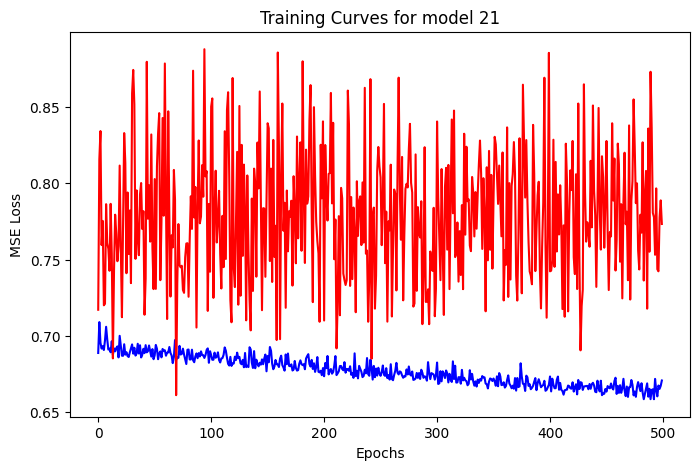

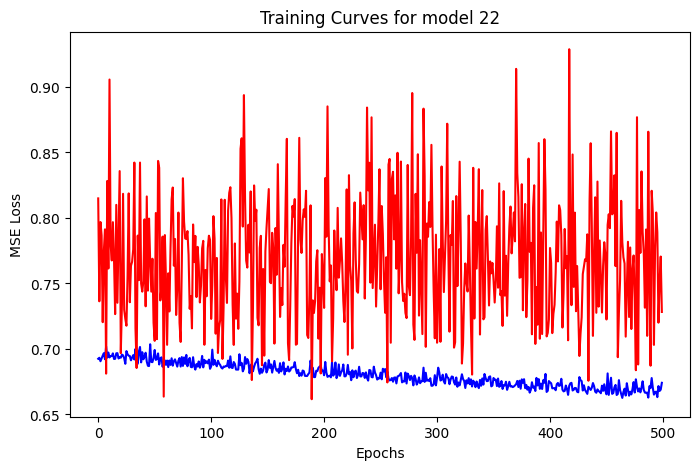

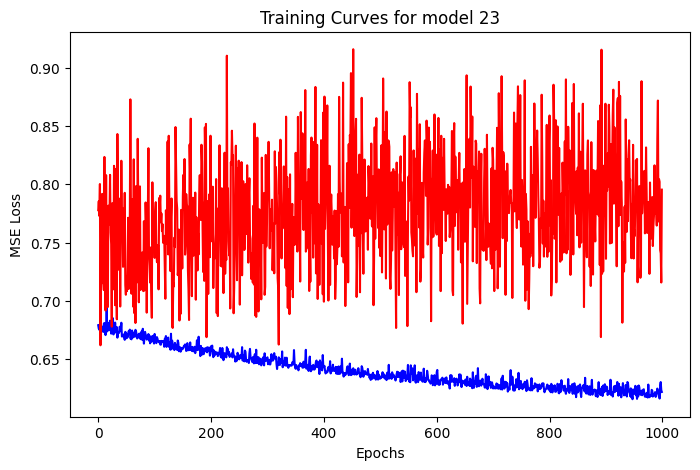

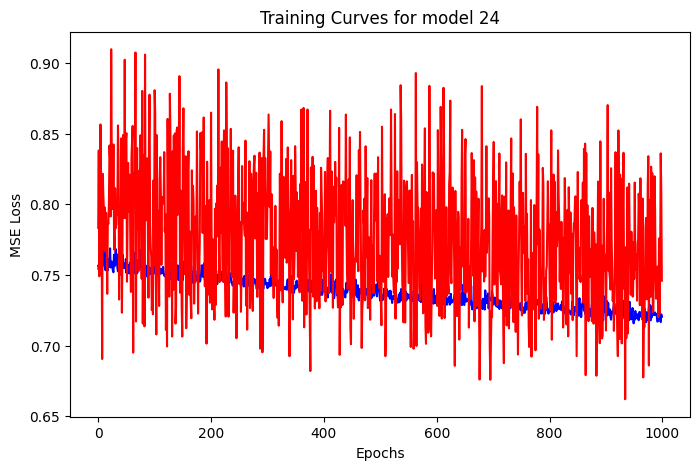

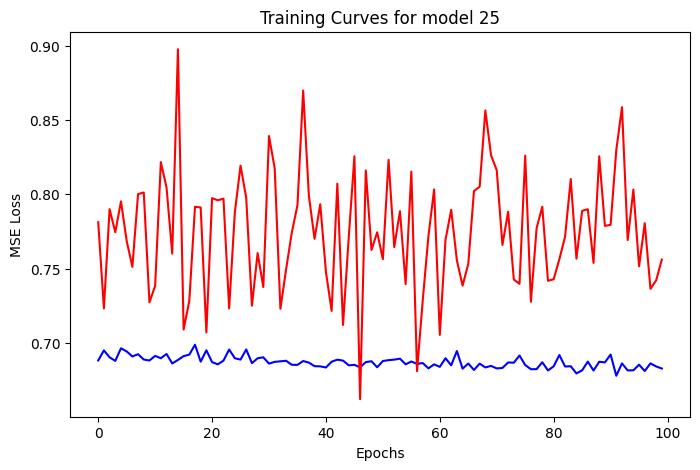

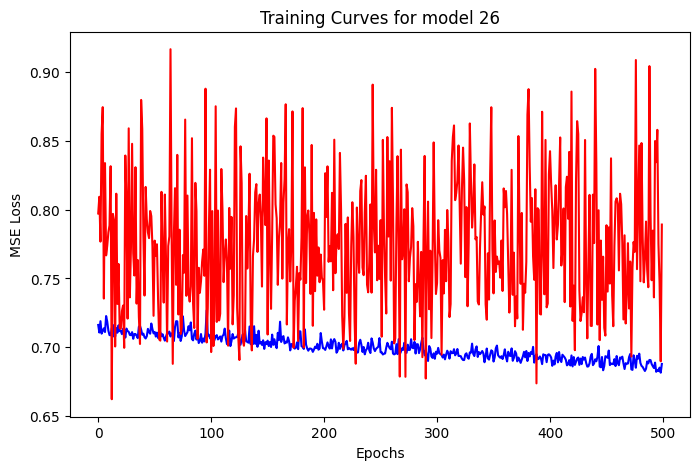

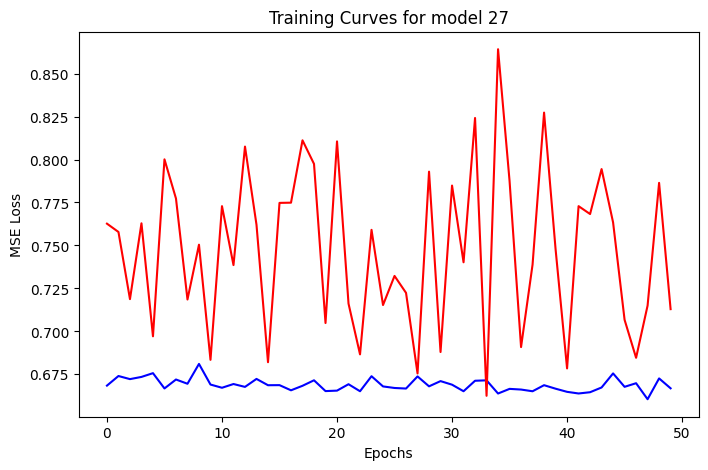

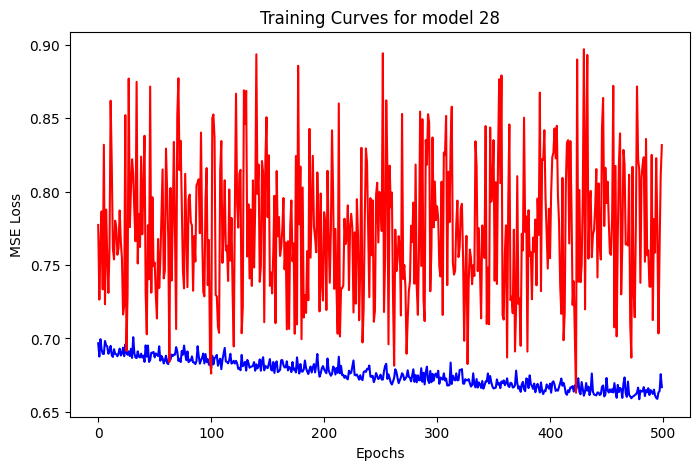

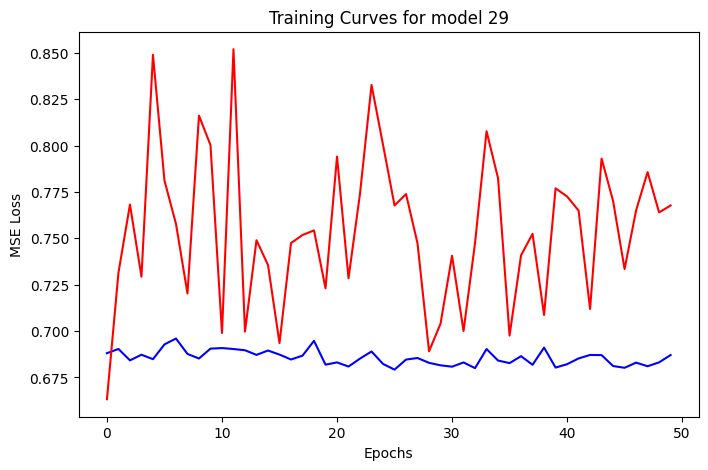

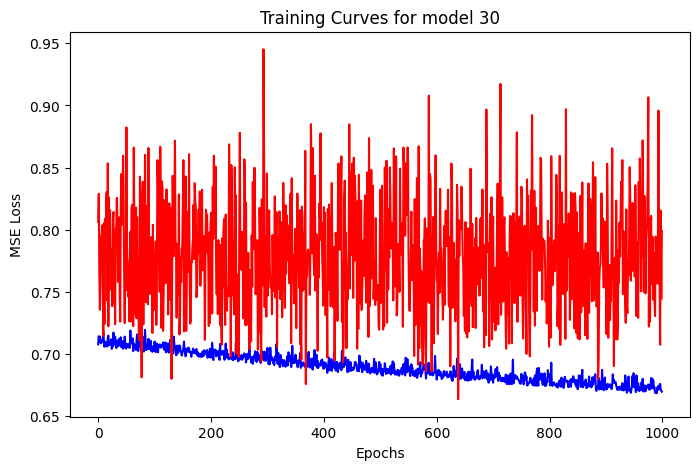

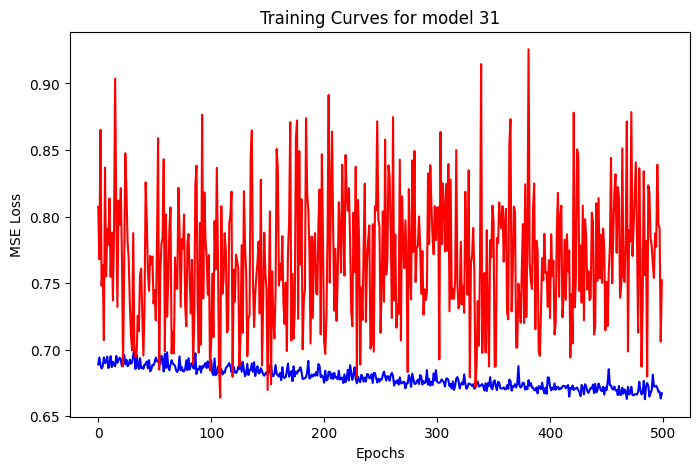

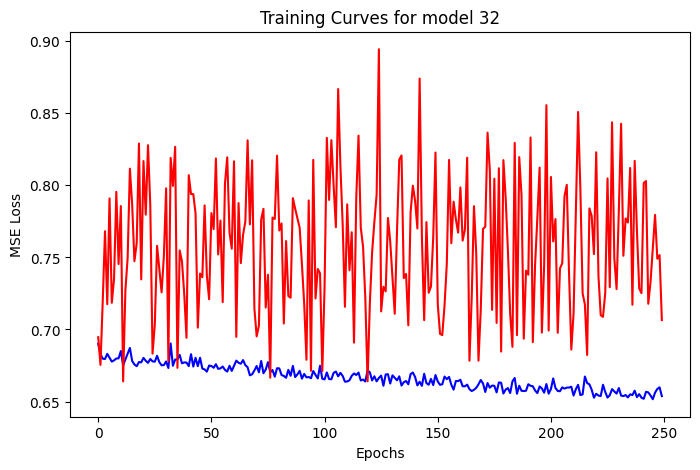

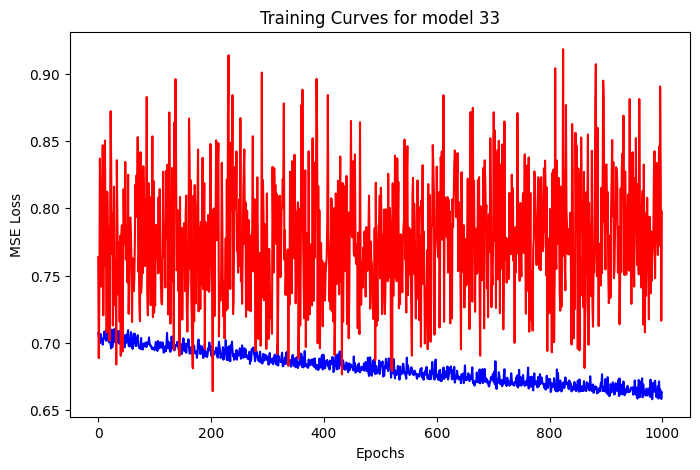

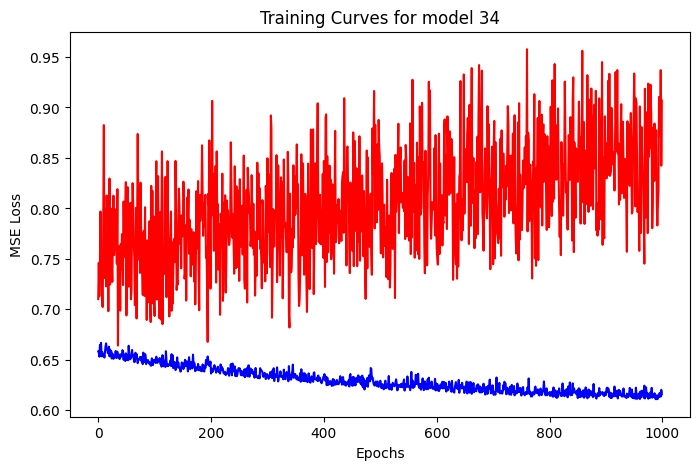

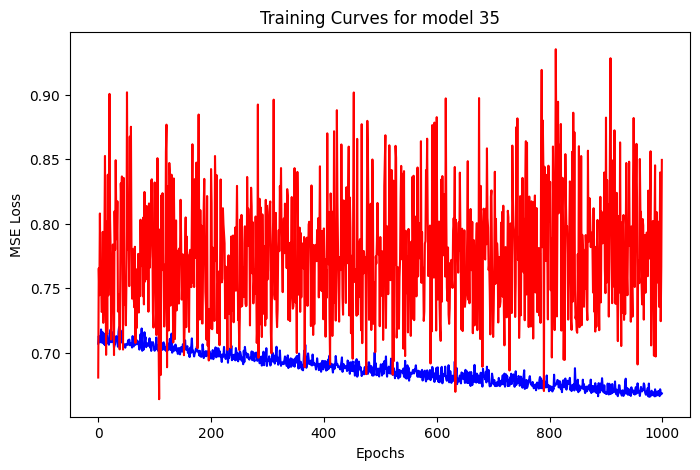

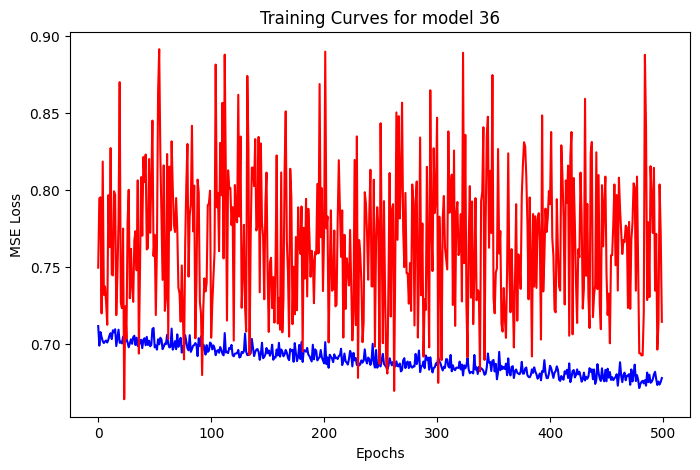

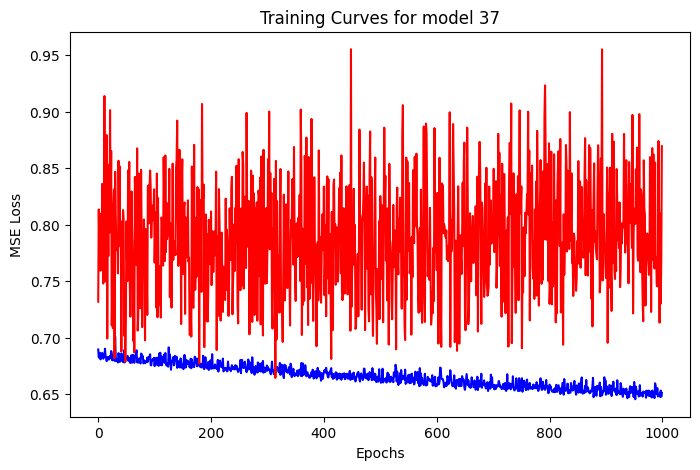

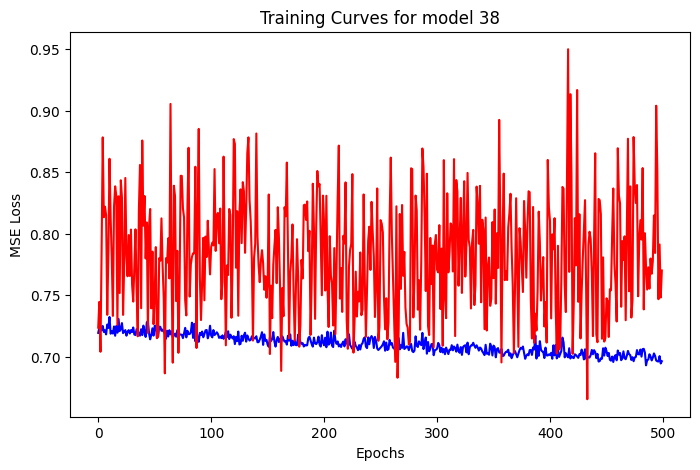

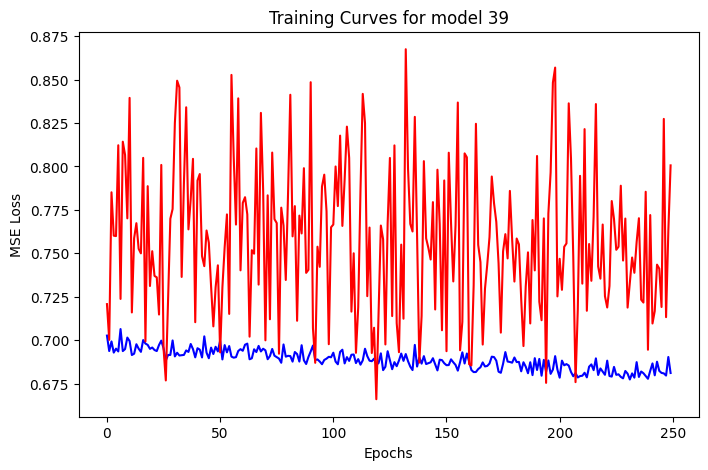

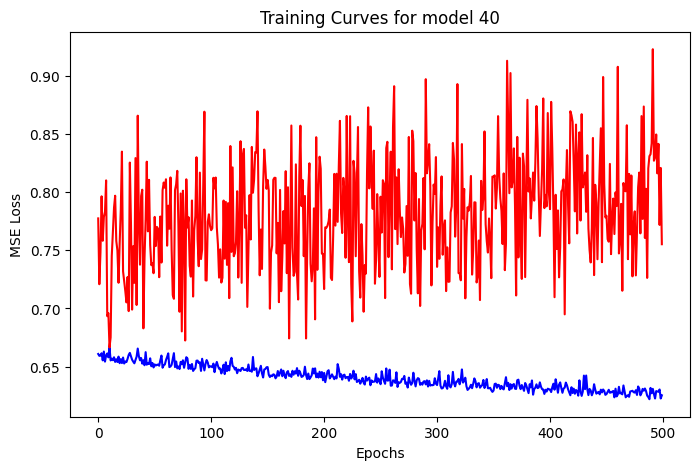

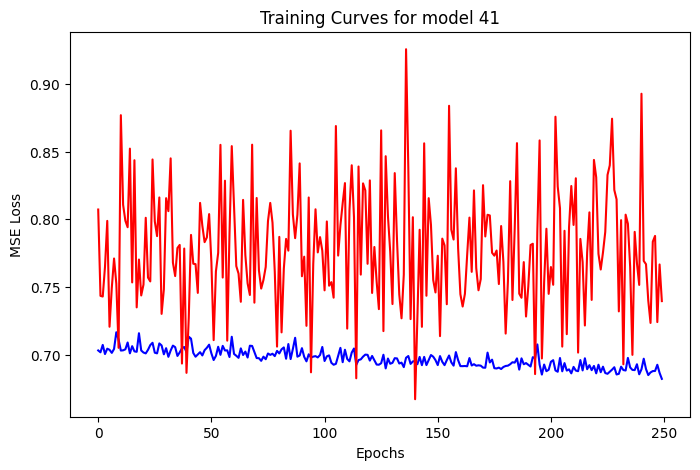

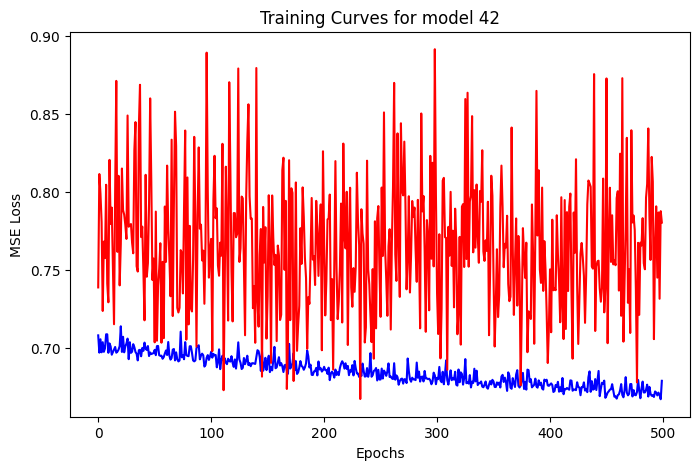

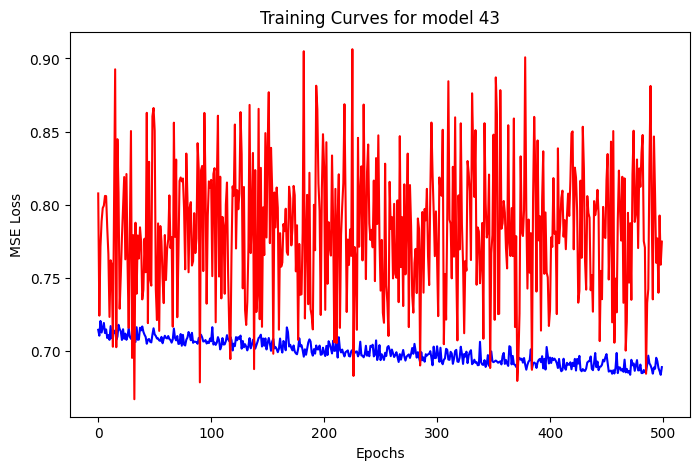

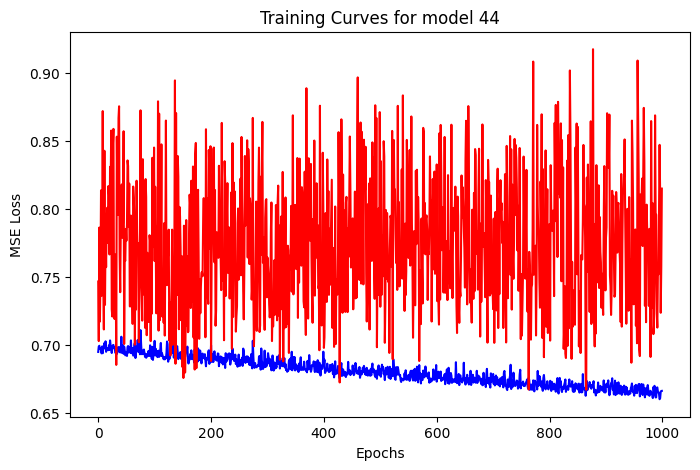

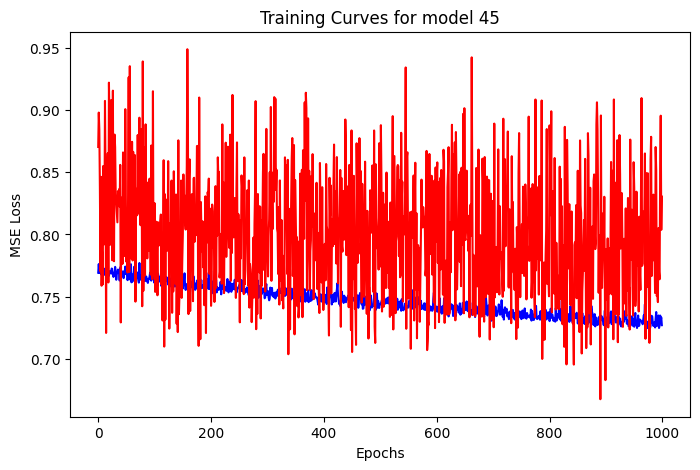

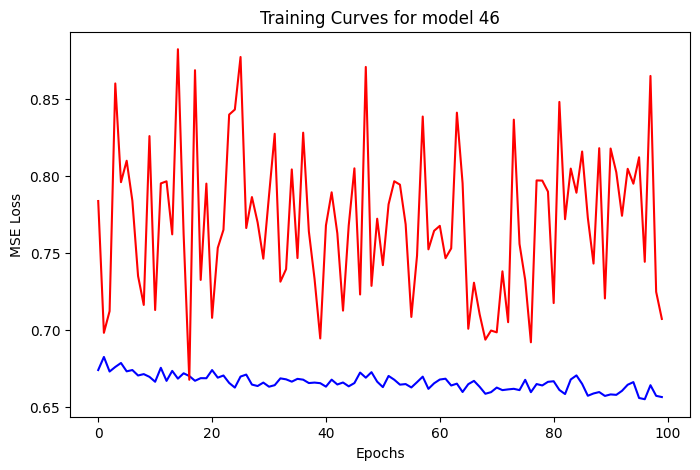

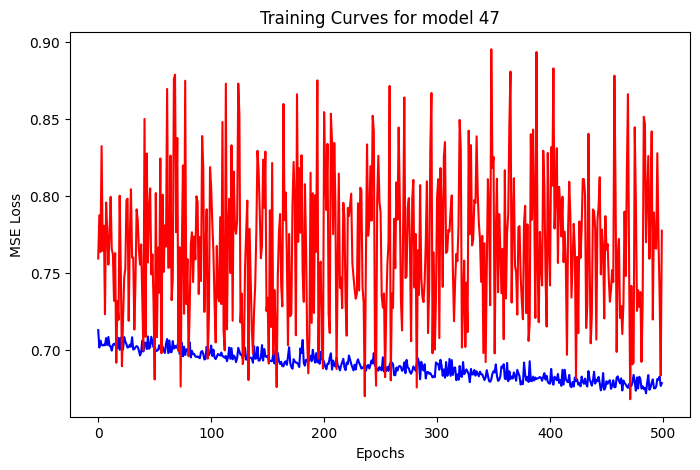

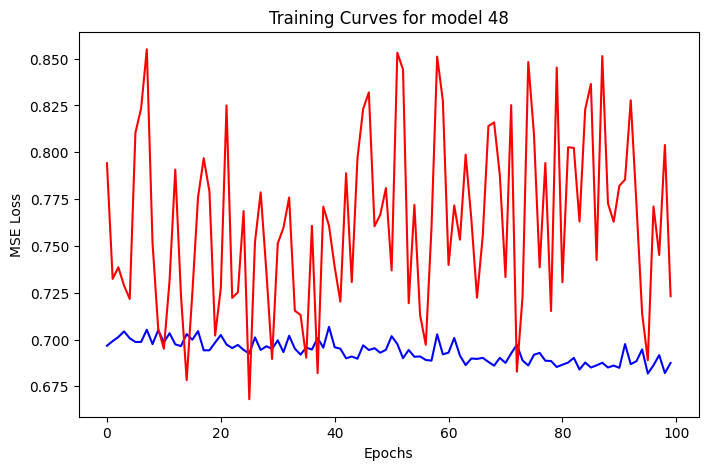

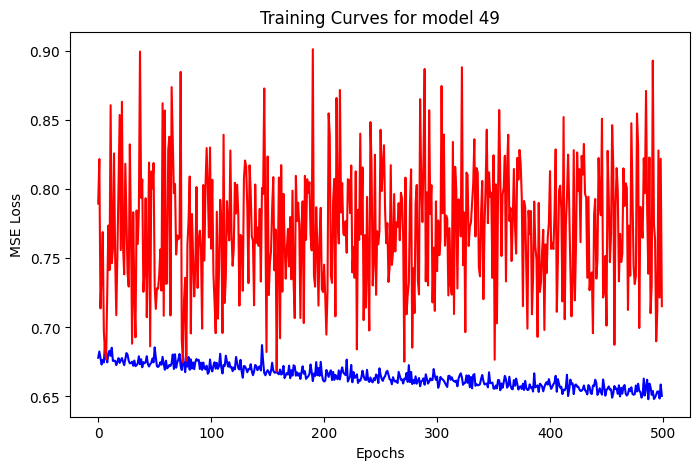

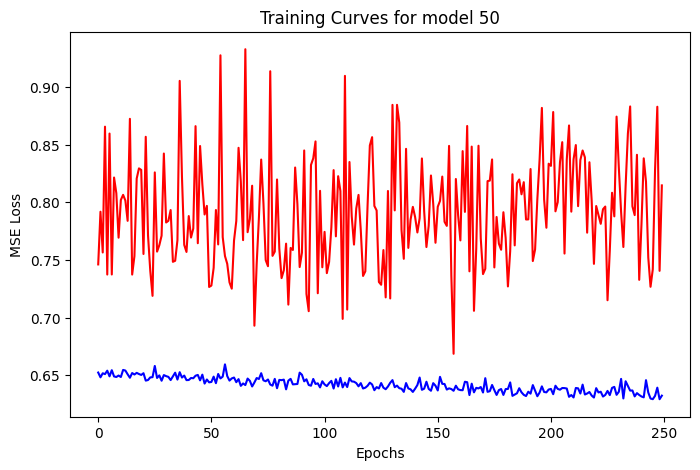

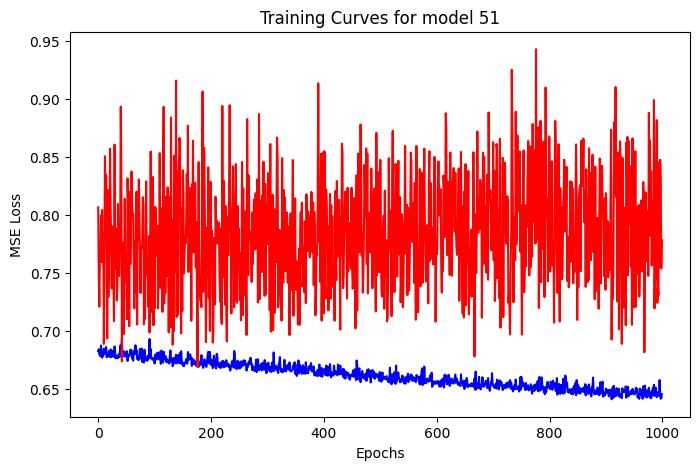

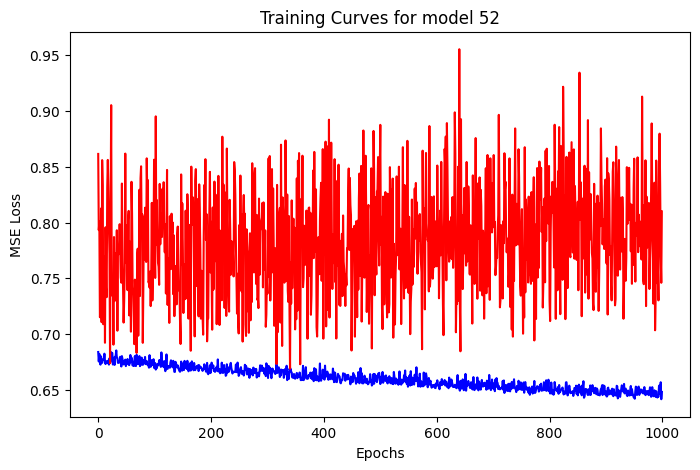

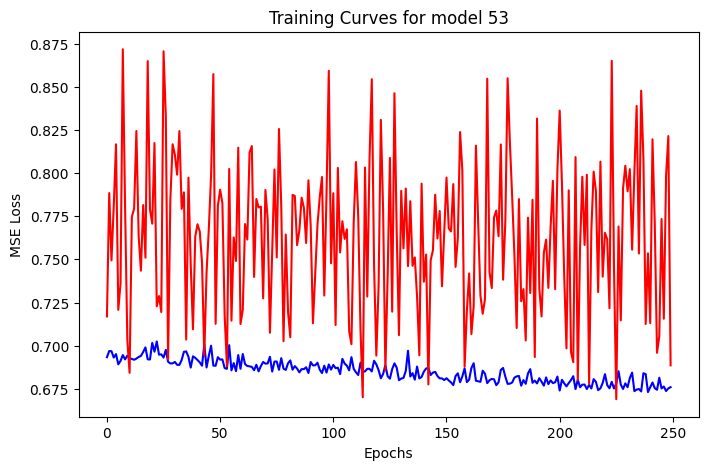

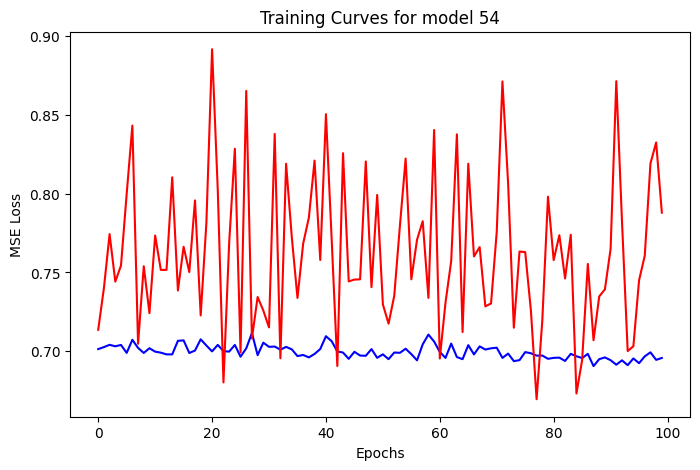

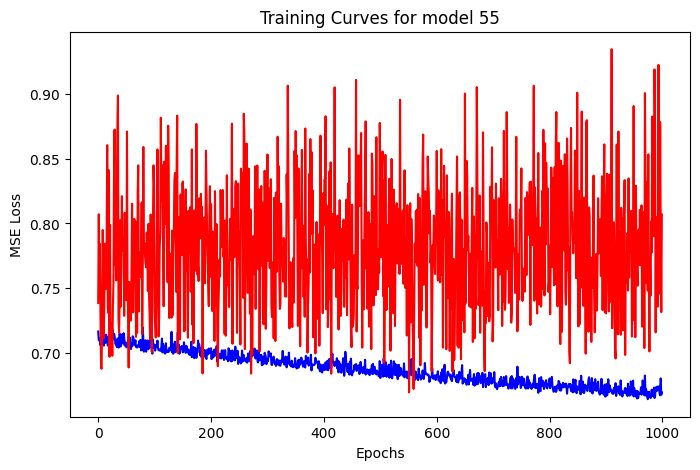

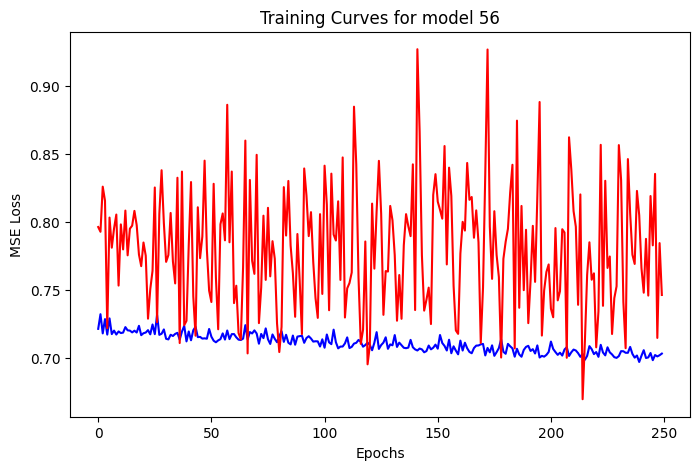

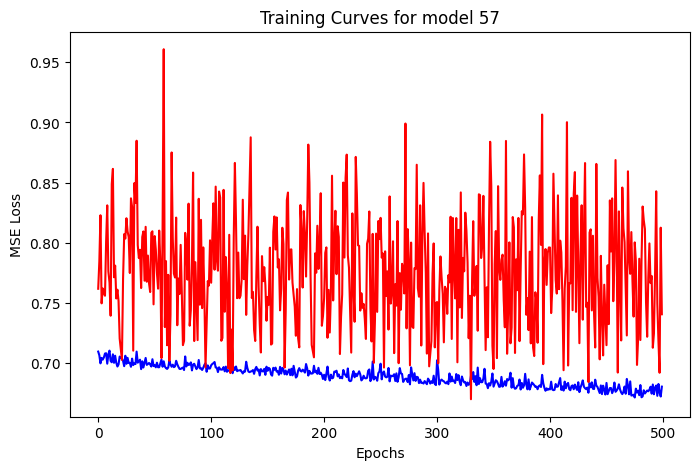

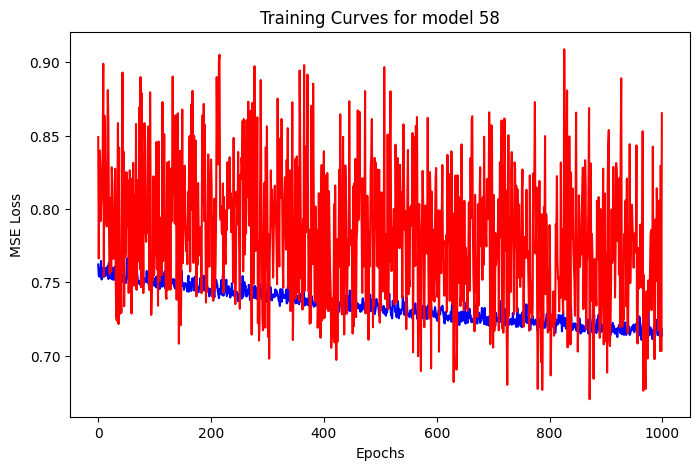

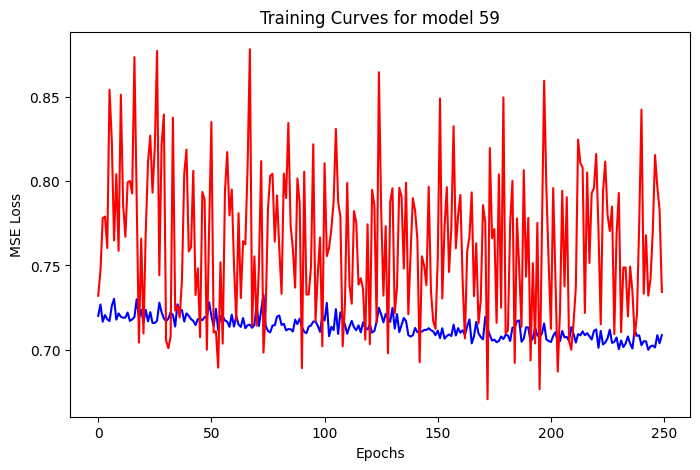

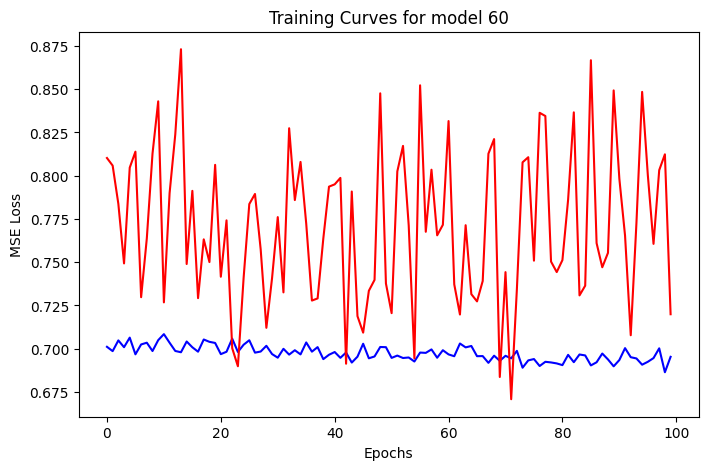

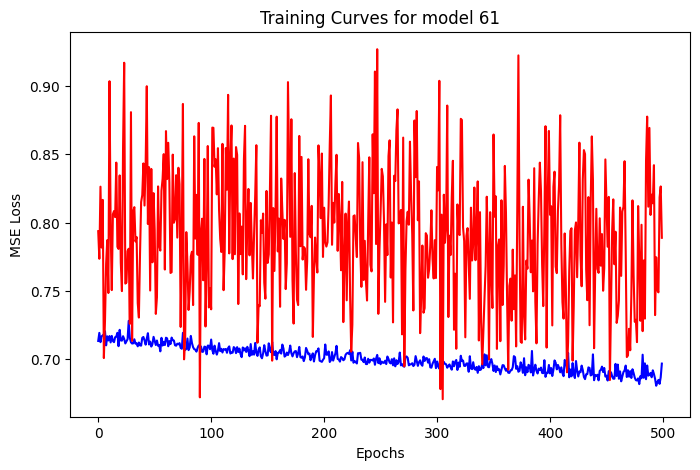

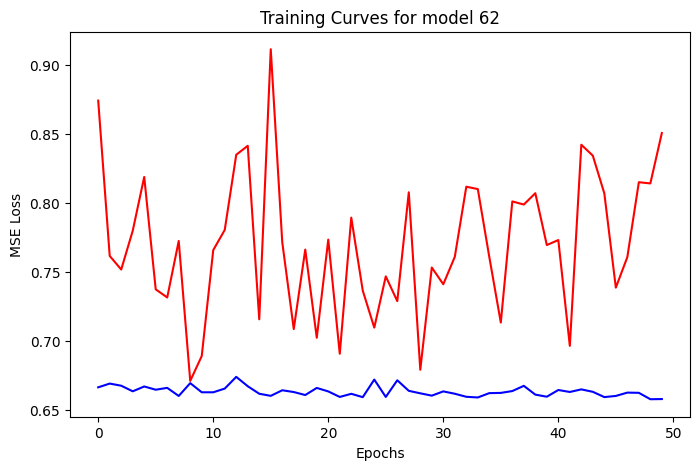

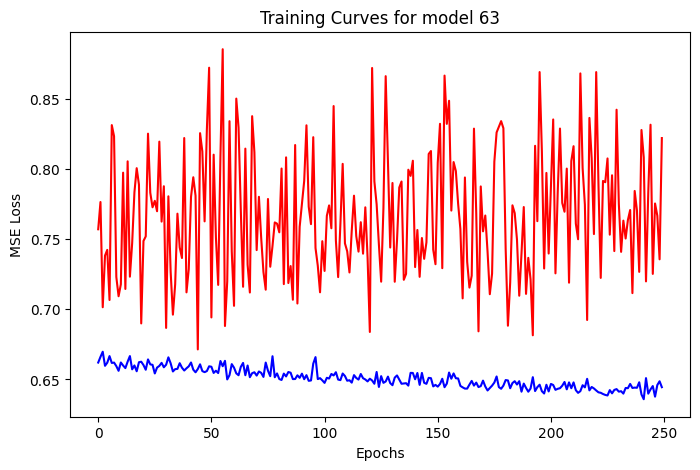

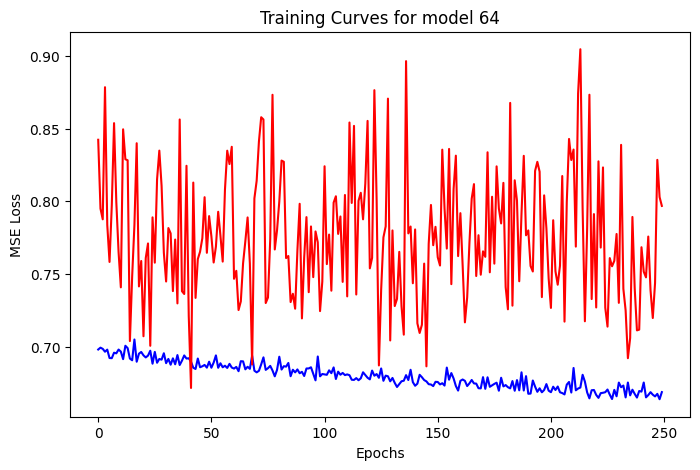

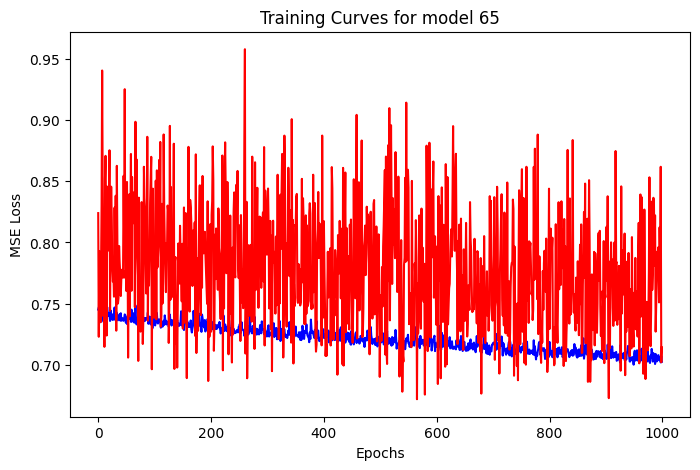

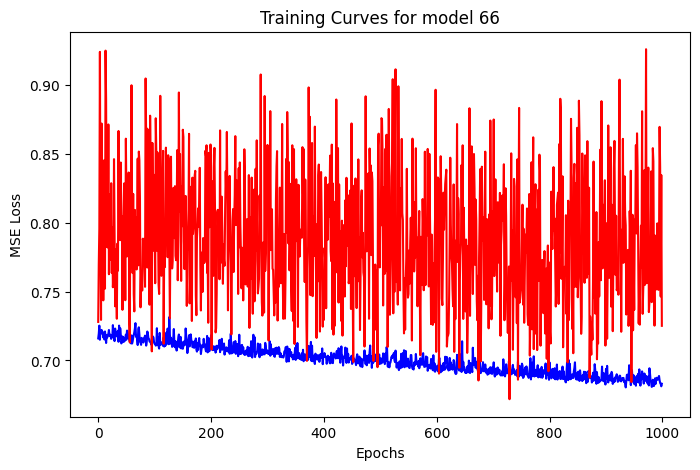

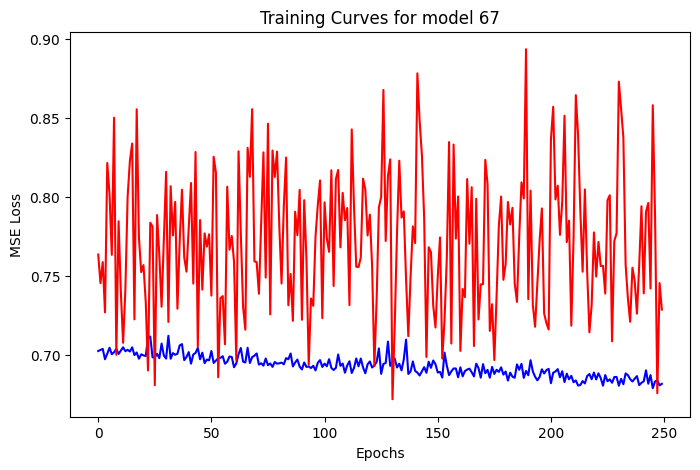

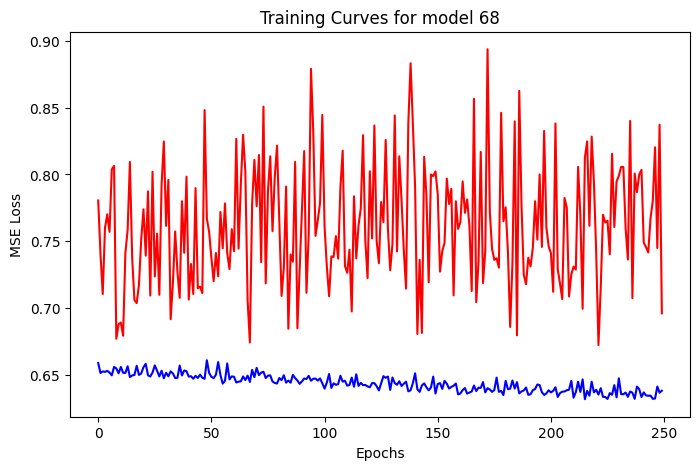

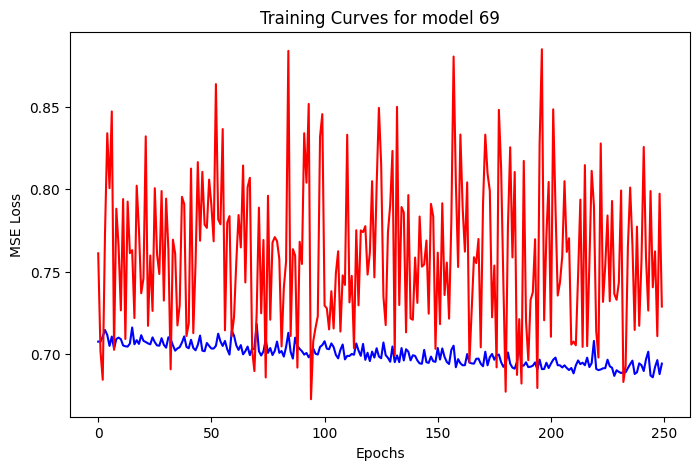

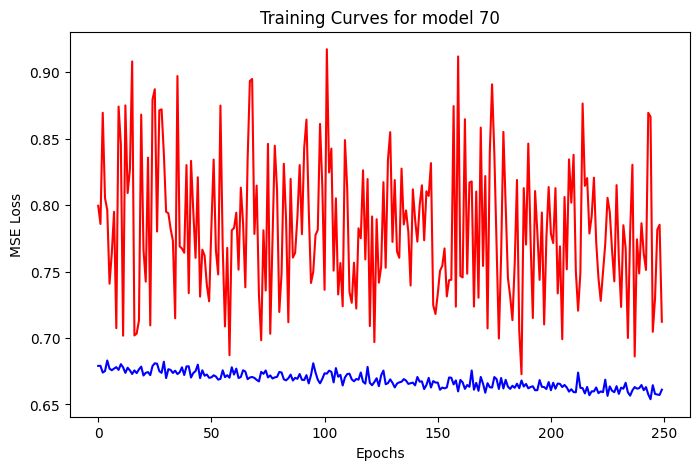

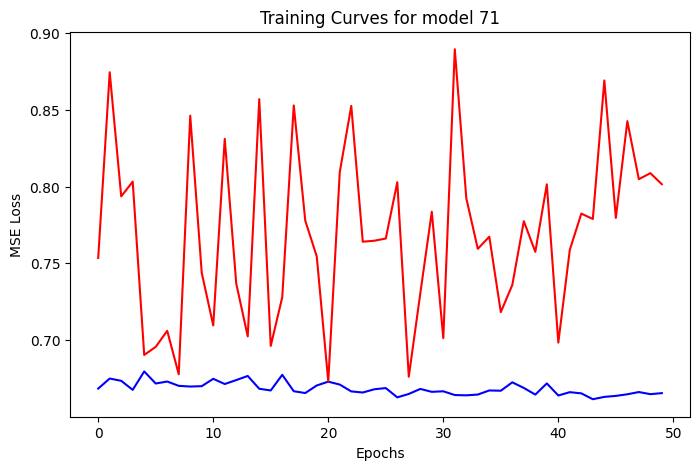

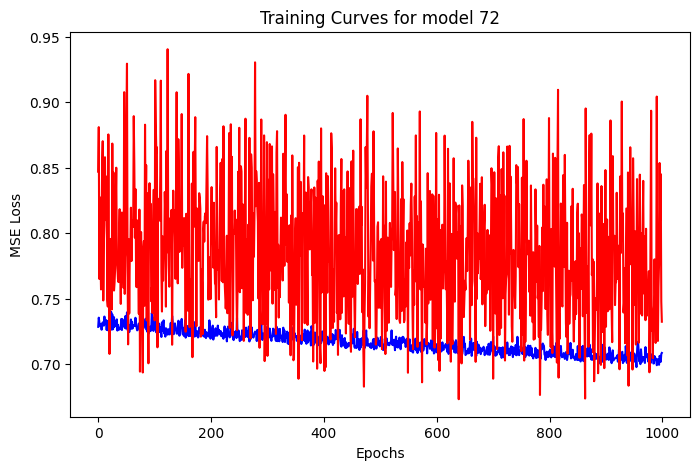

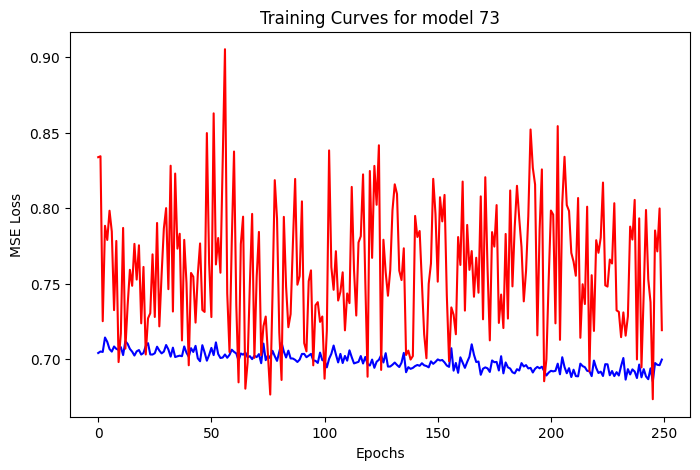

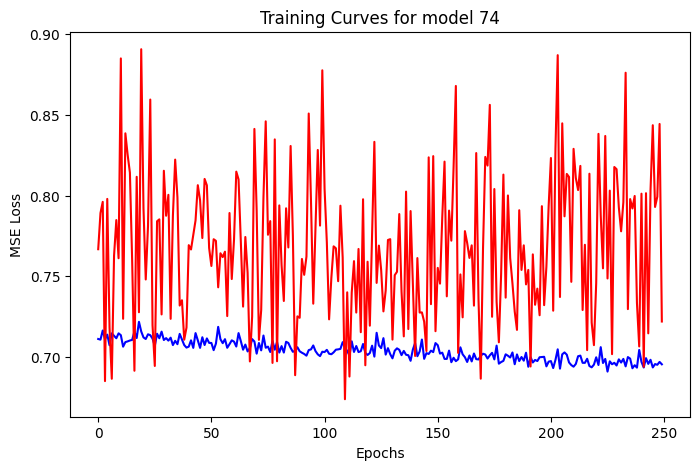

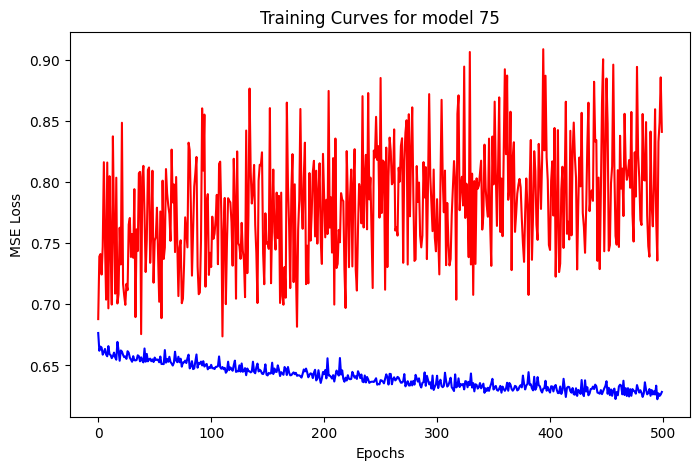

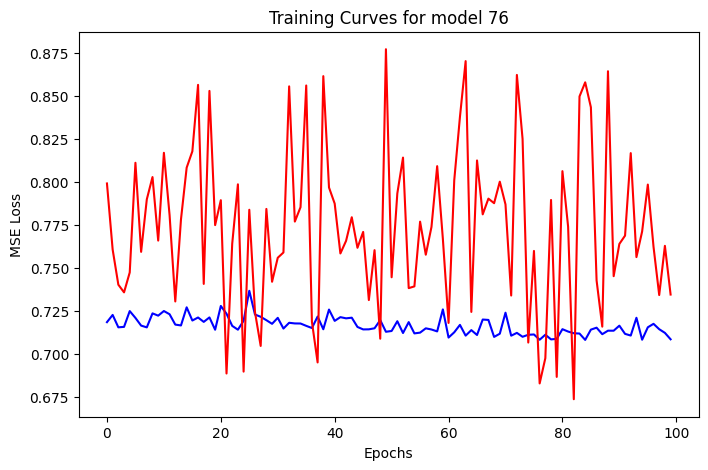

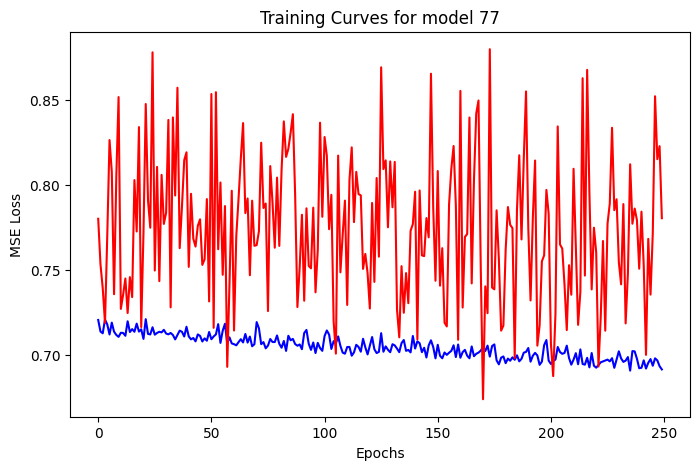

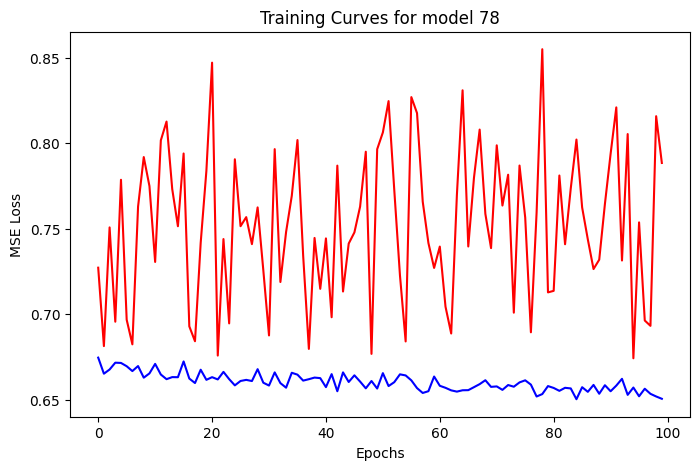

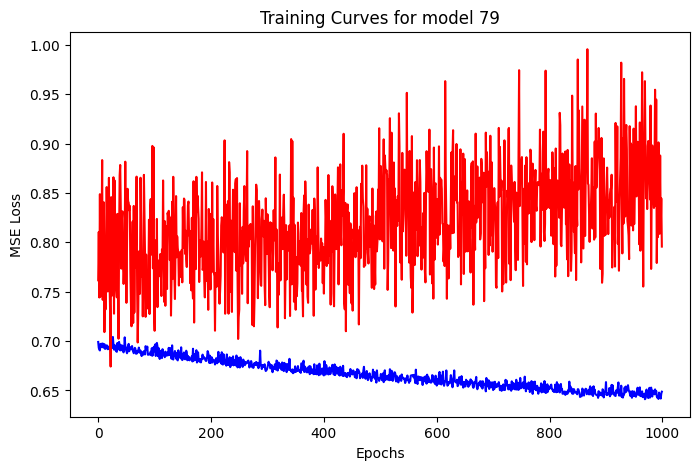

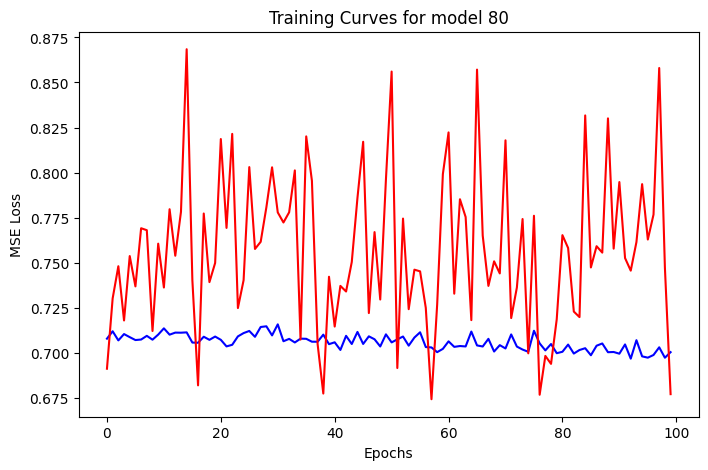

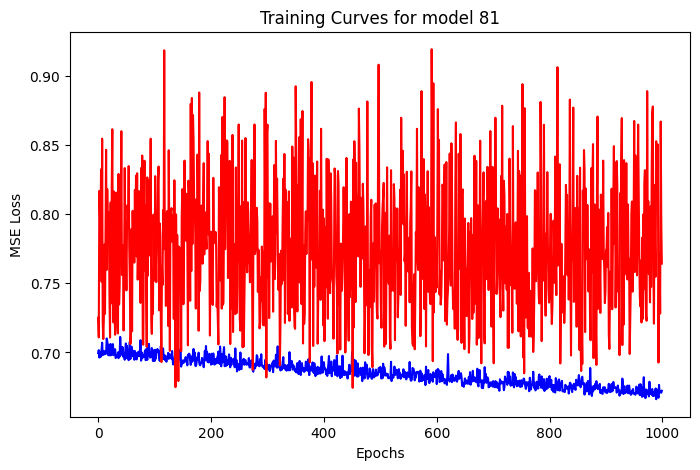

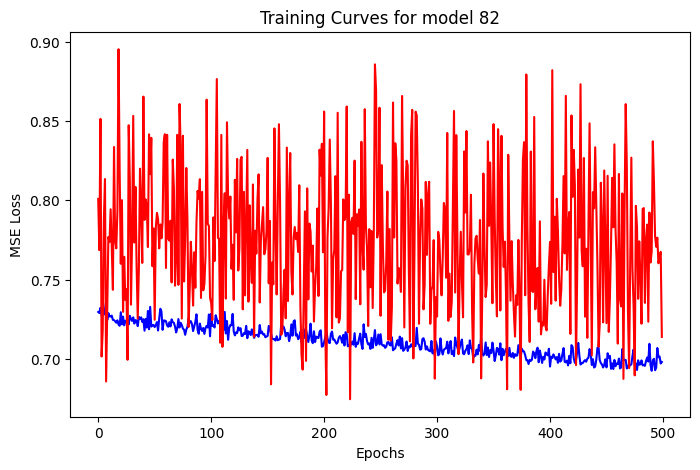

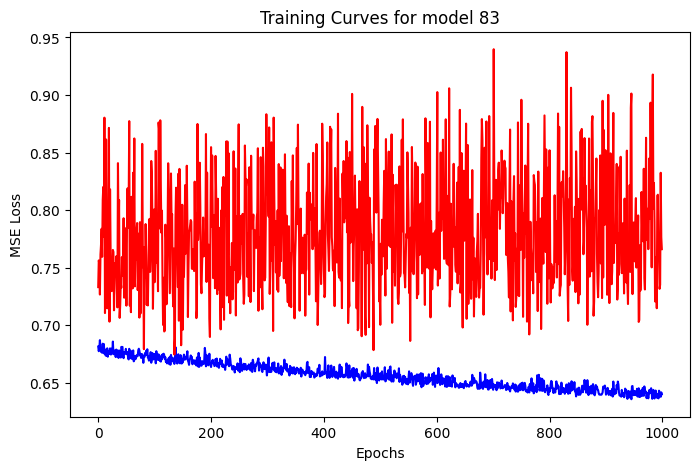

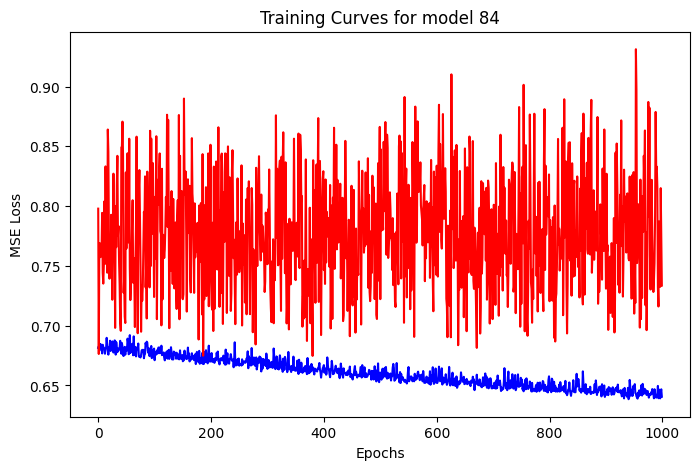

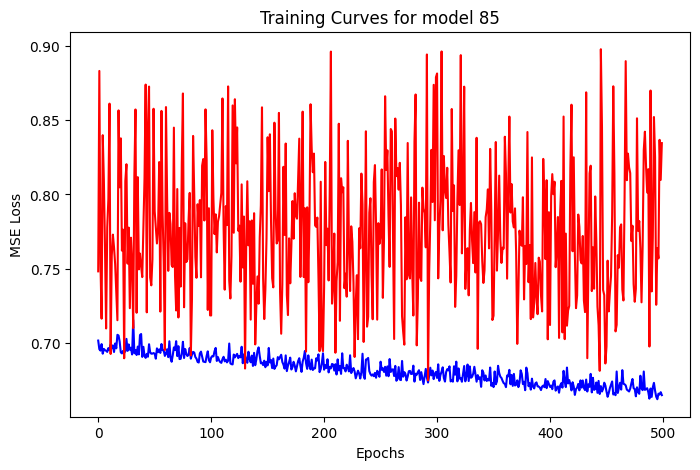

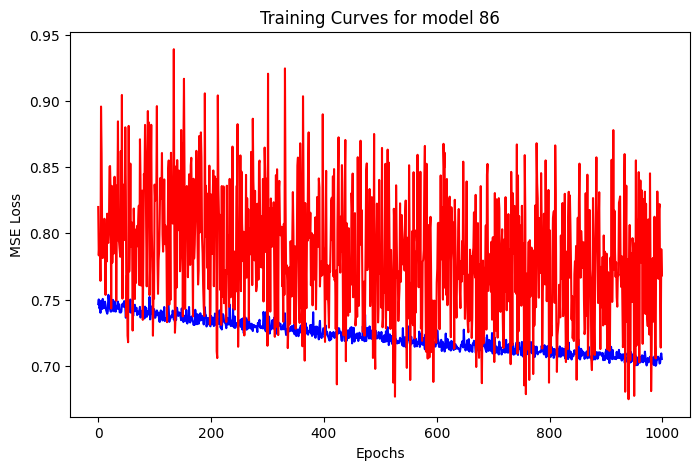

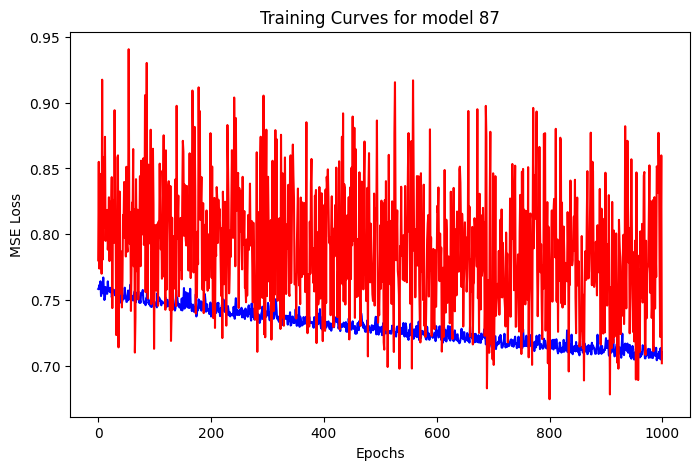

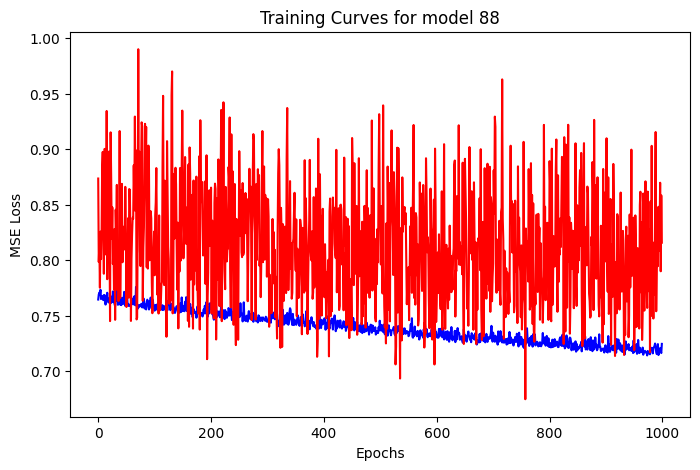

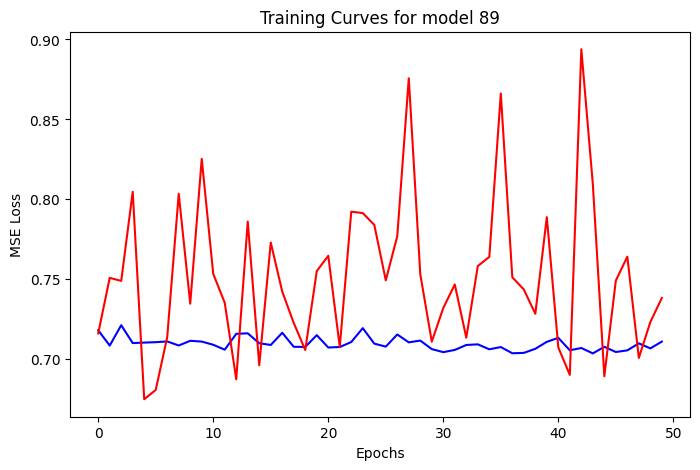

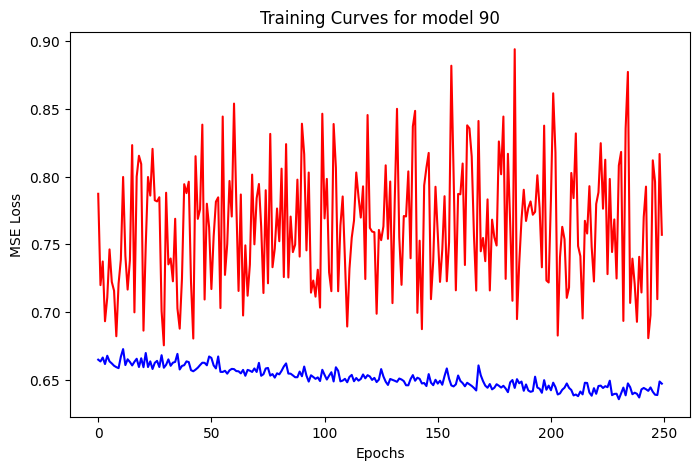

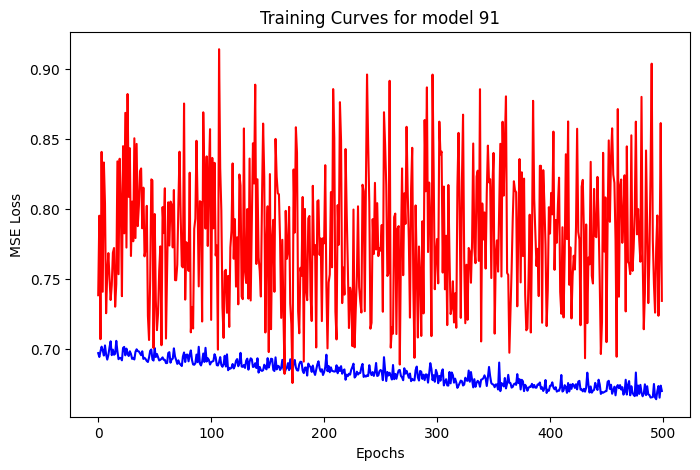

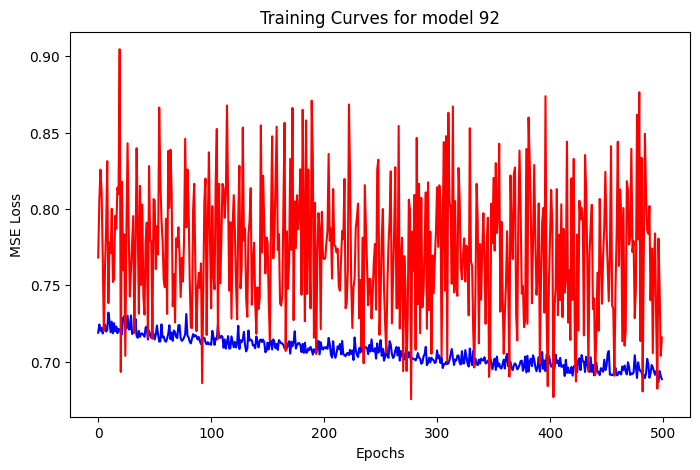

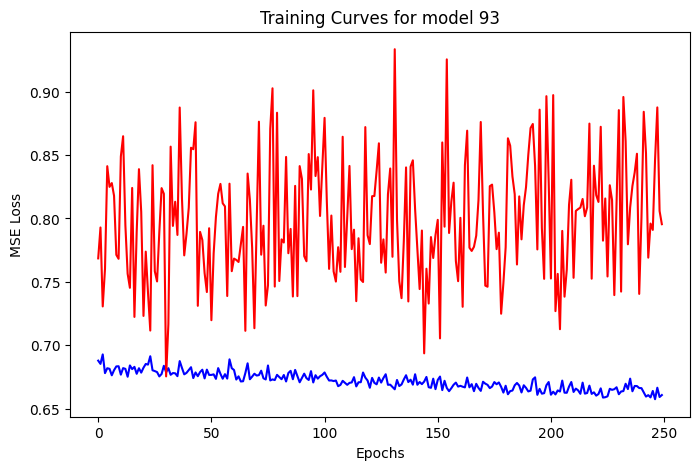

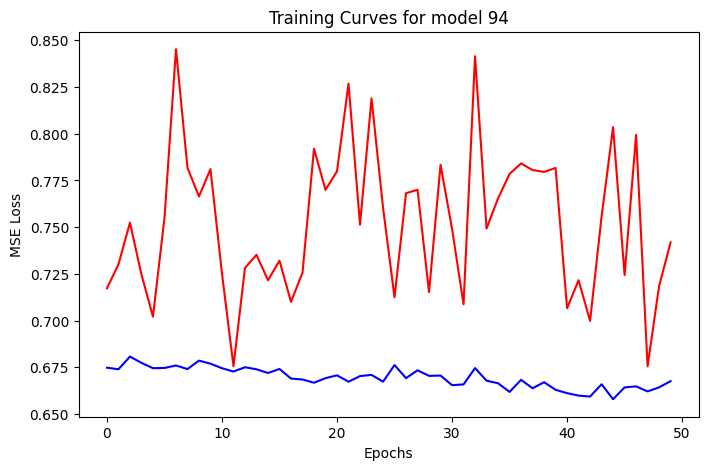

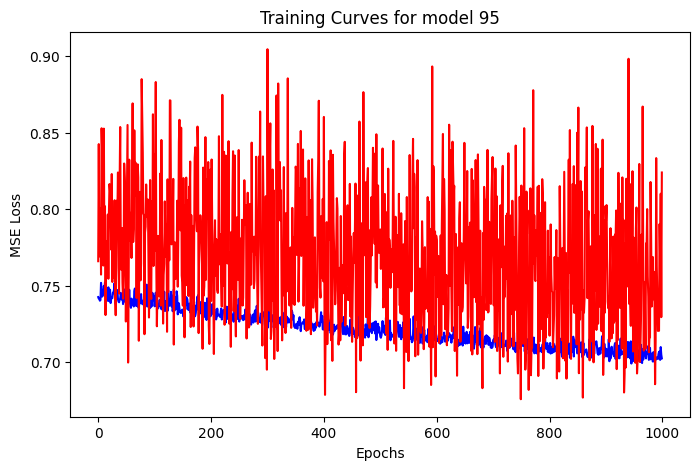

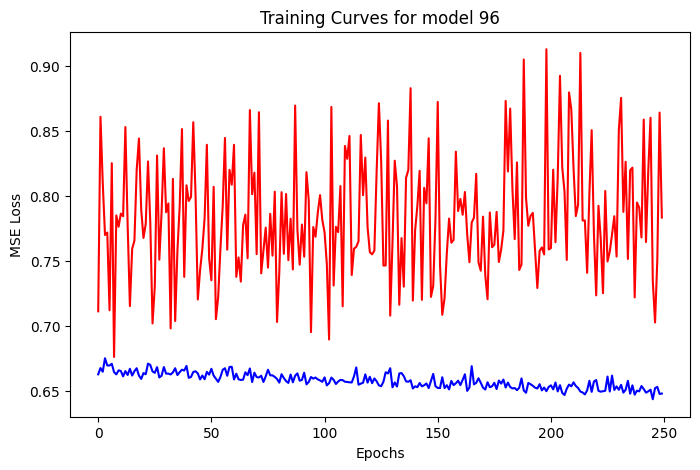

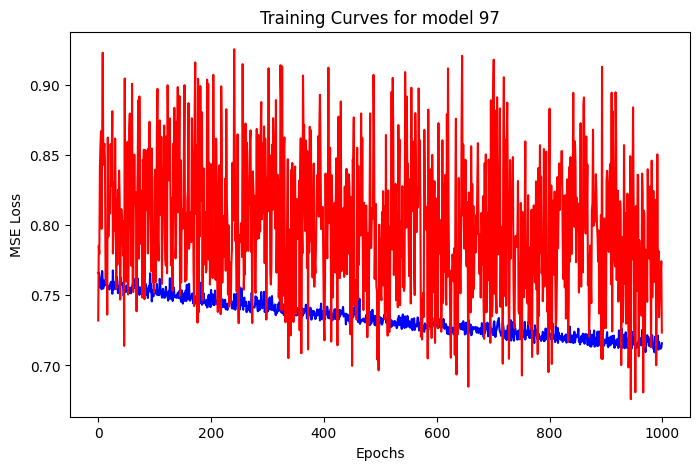

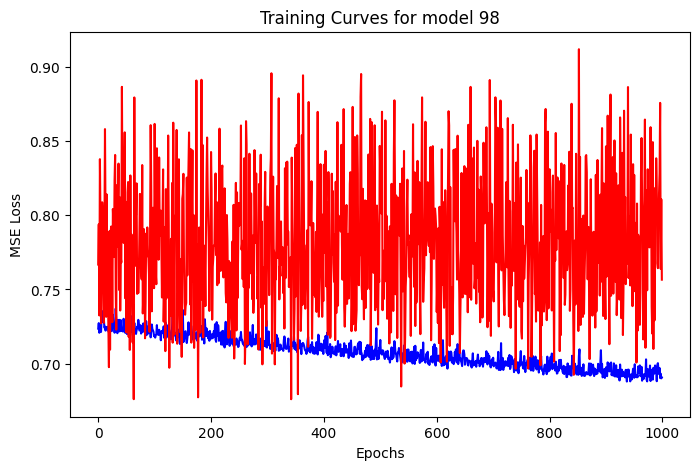

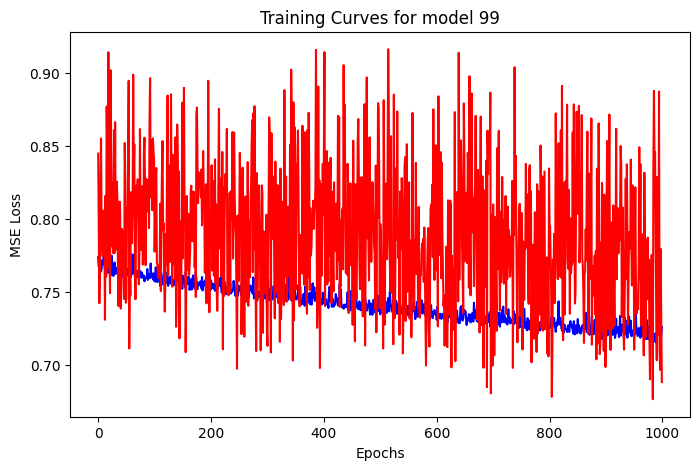

In [25]:
sorted_model_performances = model_performances.sort_values(by=['best_val_loss'], ascending=True)

for idx in range(100):
    best_model_cache = sorted_model_performances.iloc[idx, :].to_dict()
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(best_model_cache['train_losses'], label='Train Losses', color='blue')
    ax.plot(best_model_cache['val_losses'], label='Val Losses', color='red')
    ax.set(xlabel='Epochs', ylabel='MSE Loss', title=f'Training Curves for model {idx}')
    plt.show()

In [23]:
best_model_cache

{'model': CSOPFullyConnectedNN(
   (net): Sequential(
     (0): Linear(in_features=390, out_features=100, bias=True)
     (1): ReLU()
     (2): Linear(in_features=100, out_features=1, bias=True)
   )
 ),
 'train_losses': [0.9345375831638064,
  0.8810388616153172,
  0.8554071996893201,
  0.8415268212556839,
  0.8181717566081456,
  0.8105103437389646,
  0.800641587802342,
  0.7919933987515313,
  0.7943286257130759,
  0.7836518904992512,
  0.7844670968396323,
  0.7769739329814911,
  0.7720882083688464,
  0.7772811310631889,
  0.7746629459517342,
  0.7670050774301801,
  0.7612157676901136,
  0.757600588457925,
  0.7586818635463715,
  0.759267155613218,
  0.7533087879419327,
  0.7510448332343783,
  0.7501377803938729,
  0.7469066892351423,
  0.7469791131360191,
  0.743740547980581,
  0.7515141580786023,
  0.7421729394367763,
  0.745241471699306,
  0.7410108659948621,
  0.7396414854696819,
  0.7346982040575573,
  0.738543084689549,
  0.7351396701165608,
  0.7397864907979965,
  0.732358919722

In [28]:
model_path = f'feature_bagging_nn_models/fully_connected_nn_best_model_optimized'
torch.save(best_model_cache['model'], model_path)

In [24]:
def calc_nn_metrics(y_true, y_pred, type='TRAIN'):
    r2 = r2_score(y_true=y_true, y_pred=y_pred).round(4)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred).round(4)
    rmse = np.sqrt(mse).round(4)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred).round(4)

    print(f'{type} METRICS')
    print(f'R2: {r2}\tMSE: {mse}\tRMSE: {rmse}\tMAE: {mae}')

In [25]:
train_preds = best_model_cache['model'](torch.tensor(X_train.to_numpy(), dtype=torch.float32)).detach().numpy()
val_preds = best_model_cache['model'](torch.tensor(X_val.to_numpy(), dtype=torch.float32)).detach().numpy()

In [26]:
calc_nn_metrics(y_true=y_train, y_pred=train_preds, type='TRAIN')

TRAIN METRICS
R2: 0.3142	MSE: 0.6773	RMSE: 0.823	MAE: 0.5784


In [27]:
calc_nn_metrics(y_true=y_val, y_pred=val_preds, type='VALIDATION')

VALIDATION METRICS
R2: 0.3232	MSE: 0.7465	RMSE: 0.864	MAE: 0.667


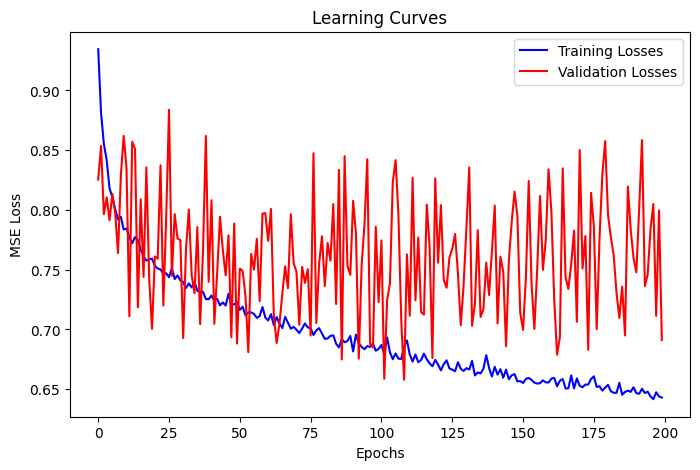

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(best_model_cache['train_losses'], color='blue', label='Training Losses')
ax.plot(best_model_cache['val_losses'], color='red', label='Validation Losses')
ax.legend()
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Learning Curves')
plt.show()